In [1]:
import numpy as np
from DSSStartup import DSSStartup
from setInfo import *
from getInfo import *
import matplotlib.pyplot as plt
from math import tan,acos
import copy
import pandas as pd
import time
from replay_buffer import ReplayBuffer
import numpy as np
#######################################################
#######################################################
###Global variable initialization and error checking###
#######################################################
#######################################################
Sbase=1
LoadScalingFactor = 1.5
GenerationScalingFactor = 5 
SlackBusVoltage = 1.04 
NoiseMultiplyer= 0

#Set simulation analysis period - the simulation is from StartTime to EndTime
StartTime = 42900
EndTime = 44000
EndTime += 1 # creating a list, last element does not count, so we increase EndTime by 1
#Set hack parameters
TimeStepOfHack = 300
PercentHacked = np.array([0,0,0,0,0, 0,0,.5,0,0,.5,.5,.5,.5,.5,0,0,.5, 0,0,0,0,0,0,0,0,0,0,0,0,0])
#PercentHacked = np.array([0,0,0,0,0, .1,.1,.1,.1,.1,.1,.1,.1,.1,.1,.1,.1,.1, 0,0,0,0,0,0,0,0,0,0,0,0,0])

#Set initial VBP parameters for uncompromised inverters
VQ_start = 1.01
VQ_end = 1.03
VP_start = 1.03
VP_end = 1.05

#Set delays for each node

Delay_VoltageSampling = np.array([0,0,0,0,0, 10,10,10,10,10,10,10,10,10,10,10,10,10, 0,0,0,0,0,0,0,0,0,0,0,0,0]) 
Delay_VBPCurveShift =   np.array([0,0,0,0,0, 60,60,60,60,60,60,60,60,60,60,60,60,60, 0,0,0,0,0,0,0,0,0,0,0,0,0])

#Set observer voltage threshold
ThreshHold_vqvp = 0.25
power_factor=0.9
pf_converted=tan(acos(power_factor))
Number_of_Inverters = 13 #even feeder is 34Bus, we only have 13 inverters


#Error checking of the global variable -- TODO: add error handling here!
if EndTime < StartTime or EndTime < 0 or StartTime < 0:
    print('Setup Simulation Times Appropriately.')
if NoiseMultiplyer < 0:
    print('Setup Noise Multiplyer Correctly.')
    
DSSStart = DSSStartup()
DSSText =DSSStart['dsstext']
DSSSolution = DSSStart['dsssolution']
DSSCircuit = DSSStart['dsscircuit']
DSSObj = DSSStart['dssobj']
DSSMon = DSSCircuit.Monitors
DSSText.command = 'Compile C:\\feeders\\feeder34_B_NR\\feeder34_B_NR.dss'
DSSSolution.Solve()
if not DSSSolution.Converged:
    print('Initial Solution Not Converged. Check Model for Convergence')
else:
    print('Initial Model Converged. Proceeding to Next Step.')
    #Doing this solve command is required for GridPV, that is why the monitors
    #go under a reset process
    DSSMon.ResetAll
    setSolutionParams(DSSObj,'daily',1,1,'off',1000000,30000)
    #Easy process to get all names and count of loads, a trick to avoid
    #some more lines of code
    TotalLoads=DSSCircuit.Loads.Count
    AllLoadNames=DSSCircuit.Loads.AllNames
    print('OpenDSS Model Compliation Done.')

#######################################################
#######################################################
####         Load data from file                    ###
#######################################################
#######################################################

#Retrieving the data from the load profile
TimeResolutionOfData=10 #resolution in minute
#Get the data from the Testpvnum folder
#Provide Your Directory - move testpvnum10 from github to drive C: 
FileDirectoryBase ='C:\\feeders\\testpvnum10\\';
QSTS_Time = list(range(1441)) #This can be changed based on the available data - for example, 1440 timesteps
QSTS_Data = np.zeros((len(QSTS_Time) ,4,TotalLoads)) #4 columns as there are four columns of data available in the .mat file

for node in range(TotalLoads):
    #This is created manually according to the naming of the folder
    FileDirectoryExtension = 'node_' + str(node+1) + '_pv_' +str(TimeResolutionOfData) + '_minute.csv'
    #The total file directory
    FileName = FileDirectoryBase + FileDirectoryExtension
    #Load the file
    MatFile = np.genfromtxt(FileName, delimiter=',')    
    QSTS_Data[:,:,node] = MatFile #Putting the loads to appropriate nodes according to the loadlist
    
Generation = QSTS_Data[:,1,:]*GenerationScalingFactor #solar generation
Load = QSTS_Data[:,3,:]*LoadScalingFactor #load demand
Generation = np.squeeze(Generation)/Sbase  #To convert to per unit, it should not be multiplied by 100
Load = np.squeeze(Load)/Sbase
print('Reading Data for Pecan Street is done.')

############################################################
############################################################
#### Interpolate to change data from minutes to seconds ####
############################################################
############################################################

from scipy.interpolate import interp1d

print('Starting Interpolation...')

#interpolation for the whole period...
Time = list(range(StartTime,EndTime))
TotalTimeSteps = len(Time)
LoadSeconds = np.empty([3600*24, TotalLoads])
GenerationSeconds = np.empty([3600*24, TotalLoads])
# Interpolate to get minutes to seconds
for node in range(TotalLoads): # i is node
    t_seconds = np.linspace(1,len(Load[:,node]), int(3600*24/1))
    f = interp1d(range(len(Load[:,node])), Load[:,node], kind='cubic', fill_value="extrapolate")
    LoadSeconds[:,node] = f(t_seconds) #spline method in matlab equal to Cubic Spline -> cubic
    
    f = interp1d(range(len(Generation[:,node])), Generation[:,node], kind='cubic', fill_value="extrapolate")
    GenerationSeconds[:,node]= f(t_seconds)

# Initialization
# then we take out only the window we want...
LoadSeconds = LoadSeconds[StartTime:EndTime,:]
GenerationSeconds = GenerationSeconds[StartTime:EndTime,:]
Load = LoadSeconds
Generation = GenerationSeconds
Origin_Load = LoadSeconds
Origin_Generation = GenerationSeconds

Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
Reading Data for Pecan Street is done.
Starting Interpolation...


In [2]:
############################################################
############################################################
#### Function for simulation################################
############################################################
############################################################

def inverter_qp_injection(counter, Vk, Vkm1, gammakm1, solar_irr, VBP, Sbar, dv, T=1, lpf=1):
    pk = 0
    qk = 0
    c = 0
    q_avail = 0

    solar_range = 5

    Vmagk = abs(Vk)
    Vmagkm1 = abs(Vkm1)
    gammakcalc = (T*lpf*(Vmagk + Vmagkm1) - (T*lpf - 2)*gammakm1)/(2 + T*lpf)

    if counter % dv == 0:
        gammakused = gammakcalc
    else :
        gammakused = gammakm1

    if solar_irr < solar_range:
        pk = 0
        qk = 0
    elif solar_irr >= solar_range:
        if gammakused <= VBP[2]:
            pk = -solar_irr
            q_avail = (Sbar**2 - pk**2)**(1/2)
            if gammakused <= VBP[0]:
                qk = 0
            elif gammakused > VBP[0] and gammakused <= VBP[1]:
                c = q_avail/(VBP[1] - VBP[0])
                qk = c*(gammakused - VBP[0])
            else:
                qk = q_avail
        elif gammakused > VBP[2] and gammakused < VBP[3]:
            d = -solar_irr/(VBP[3] - VBP[2])
            pk = -(d*(gammakused - VBP[2]) + solar_irr)
            qk = (Sbar**2 - pk**2)**(1/2)
        elif gammakused >= VBP[3]:
            qk = Sbar
            pk = 0
    return qk,pk, gammakused
    
def voltage_observer(vk, vkm1, psikm1, epsilonkm1, ykm1, f_hp=1, f_lp=0.1, gain=1e5, T=1):
    Vmagk = abs(vk)
    Vmagkm1 = abs(vkm1)
    psik = (Vmagk - Vmagkm1 - (f_hp*T/2-1)*psikm1)/(1+f_hp*T/2)
    epsilonk = gain*(psik**2)
    yk = (T*f_lp*(epsilonk + epsilonkm1) - (T*f_lp - 2)*ykm1)/(2 + T*f_lp)
    return yk, psik, epsilonk

def adaptive_control(delay, vk, vkmdelay, ukmdelay, thresh, yk):
    if (yk > thresh):
        uk = delay/2*k * ( vk**2 + vkmdelay**2 ) + ukmdelay
    else:
        uk = ukmdelay
    return uk

In [3]:
#support function
def processing_state(V, G, L):
    state = np.array([V, G, L]).T
    result = np.zeros((60,3))
    result[:state.shape[0],:state.shape[1]] = state #padding with zeros
    state = result.copy()
    return state

In [4]:
#this is the agent
import tensorflow as tf
EPS = 1e-6

def build_graph(inputs, layer_sizes):
    if type(inputs) is tf.Tensor:
        inputs = [inputs]
    
    with tf.variable_scope('layer0'):
        state = inputs[0]
        lstm_cell = tf.contrib.rnn.LSTMCell(num_units=32, use_peepholes=True)
        outputs, states = tf.nn.dynamic_rnn(lstm_cell, state, dtype=tf.float32)
        state0 = tf.layers.dense(states.h, 30)
        if len(inputs) != 1:
            action = inputs[1]
            action0 = tf.layers.dense(action, 30)
            layer = action0 + state0
        else: 
            layer = state0
        layer = tf.nn.relu(layer)
    
    for i_layer, size in enumerate(layer_sizes, 1):
        with tf.variable_scope('layer{0}'.format(i_layer)):
            layer = tf.layers.dense(layer, size)
            if i_layer < len(layer_sizes) - 1:
                layer = tf.nn.relu(layer)
    
    #layer = tf.squeeze(layer)
    
    return layer

class NNFunction():
    def __init__(self, name, input_pls, hidden_layer_sizes):
        self._name = name
        self._input_pls = input_pls
        self._layer_sizes = list(hidden_layer_sizes) + [1]
        self._output_t = self.get_output_for(*self._input_pls)
    def get_output_for(self, *inputs, reuse=False):
        with tf.variable_scope(self._name, reuse=reuse):
            value_t = build_graph(inputs=inputs, layer_sizes=self._layer_sizes)
        return value_t
    
    def get_params_internal(self):

        scope = tf.get_variable_scope().name
        scope += '/' + self._name + '/' if len(scope) else self._name + '/'
        return tf.get_collection(
            tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope
        )
    
class NNVFunction(NNFunction):
    def __init__(self, hidden_layer_sizes=(30, 30), name='vf'):
        self._Do = [60,3]
        self._obs_pl = tf.placeholder(tf.float32, shape=[None] + self._Do, name='observation')
        super(NNVFunction, self).__init__(name, (self._obs_pl,), hidden_layer_sizes)


class NNQFunction(NNFunction):
    def __init__(self, hidden_layer_sizes=(30, 30), name='qf'):
        self._Da = 4
        self._Do = [60,3]
        self._obs_pl = tf.placeholder(tf.float32, shape=[None]+ self._Do, name='observation')
        self._action_pl = tf.placeholder(tf.float32, shape=[None, self._Da], name='action')
        super(NNQFunction, self).__init__(name, (self._obs_pl, self._action_pl), hidden_layer_sizes)

#############################################################        
class Normal():
    def __init__(self, hidden_layer_sizes, D, obs, reparameterize, reg):
        self._layer_sizes = list(hidden_layer_sizes) + [2*D]
        self._reparameterize = reparameterize
        self._reg = reg
        self._obs = obs
        self._D = D
        self._create_graph()
    def _create_graph(self, LOG_SIG_CAP_MIN=-200, LOG_SIG_CAP_MAX=-0.5):
        Dx = self._D
        mu_and_logsig_t = build_graph(inputs=self._obs, layer_sizes=self._layer_sizes)
        self._mu_t = mu_and_logsig_t[..., :Dx]
        self._log_sig_t = tf.clip_by_value(mu_and_logsig_t[..., Dx:], LOG_SIG_CAP_MIN, LOG_SIG_CAP_MAX)

        # Tensorflow's multivariate normal distribution supports reparameterization
        ds = tf.contrib.distributions
        dist = ds.MultivariateNormalDiag(loc=self._mu_t, scale_diag=tf.exp(self._log_sig_t))
        x_t = dist.sample()
        if not self._reparameterize:
            x_t = tf.stop_gradient(x_t)
        log_pi_t = dist.log_prob(x_t)

        self._dist = dist
        self._x_t = x_t
        self._log_pi_t = log_pi_t
        
        reg_loss_t = self._reg * 0.5 * tf.reduce_mean(self._log_sig_t ** 2)
        reg_loss_t += self._reg * 0.5 * tf.reduce_mean(self._mu_t ** 2)
        self._reg_loss_t = reg_loss_t
    
    @property
    def log_p_t(self):
        return self._log_pi_t

    @property
    def reg_loss_t(self):
        return self._reg_loss_t

    @property
    def x_t(self):
        return self._x_t

    @property
    def mu_t(self):
        return self._mu_t

    @property
    def log_sig_t(self):
        return self._log_sig_t
    
class GaussianPolicy():
    def __init__(self, hidden_layer_sizes=(30,30), reparameterize=False, name='policy', squash=True):
        self._name = name
        self._Do = [60,3]
        self._Da = 4
        self._obs_pl = tf.placeholder(tf.float32, shape=[None] + self._Do, name='observation')
        self._action_pl = tf.placeholder(tf.float32, shape=[None, self._Da], name='action')
        self._layer_sizes = hidden_layer_sizes
        self._squash = squash
        self._reparameterize = reparameterize
    def actions_for(self, observations, reuse=tf.AUTO_REUSE, with_log_pis = True):
        name = self._name
        with tf.variable_scope(name, reuse=reuse):
            distribution = Normal(hidden_layer_sizes = self._layer_sizes, D = self._Da, obs=(observations,), 
                                 reparameterize=self._reparameterize, reg=True)
        
        raw_actions = distribution.x_t
        actions = tf.tanh(raw_actions) if self._squash else raw_actions
        
        if with_log_pis:
            log_pis = distribution.log_p_t
            if self._squash:
                log_pis -= self._squash_correction(raw_actions)
            return actions, log_pis
        
        return actions    
    
    def get_params_internal(self):

        scope = tf.get_variable_scope().name
        scope += '/' + self._name + '/' if len(scope) else self._name + '/'
        return tf.get_collection(
            tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope
        )
    
    def _squash_correction(self, actions):
        if not self._squash: return 0
        return tf.reduce_sum(tf.log(1 - tf.tanh(actions) ** 2 + EPS), axis=1)
    
    def name(self):
        return self._name

class agent():
    def __init__(self, sess, observations_ph, next_observations_ph, rewards_ph, actions_ph, terminals_ph, name='agent'):
        self._observations_ph = observations_ph
        self._next_observations_ph = next_observations_ph
        self._rewards_ph = rewards_ph
        self._actions_ph= actions_ph
        self._terminals_ph = terminals_ph
        
        self._discount = 0.99
        self._tau = 0.01
        
        self._qf_lr = 0.1
        self._vf_lr = 0.1
        self._policy_lr = 0.01
        self._action_prior = 'Normal'
        self._reparameterize = False
        self._sess = sess
        self._training_ops = []
        with tf.variable_scope(name):
            self._vf = NNVFunction((30,30))
            self._qf1 = NNQFunction((30,30), 'qf1')
            self._qf2 = NNQFunction((30,30), 'qf2')
            self._policy = GaussianPolicy(hidden_layer_sizes=(30,30), reparameterize=self._reparameterize)
            self._init_critic_update()
            self._init_actor_update()
            self._init_target_ops()
            
        uninit_vars = []
        for var in tf.global_variables():
            try:
                self._sess.run(var)
            except tf.errors.FailedPreconditionError:
                uninit_vars.append(var)
        self._sess.run(tf.variables_initializer(uninit_vars))
        
        self._init_training()
        
    def _init_critic_update(self):
        self._qf1_t = self._qf1.get_output_for(
            self._observations_ph, self._actions_ph, reuse=True)  # N
        self._qf2_t = self._qf2.get_output_for(
            self._observations_ph, self._actions_ph, reuse=True)  # N

        with tf.variable_scope('target'):
            vf_next_target_t = self._vf.get_output_for(self._next_observations_ph)  # N
            self._vf_target_params = self._vf.get_params_internal()

        ys = tf.stop_gradient(
            self._rewards_ph +
            (1 - self._terminals_ph) * self._discount * vf_next_target_t
        )  # N

        self._td_loss1_t = 0.5 * tf.reduce_mean((ys - self._qf1_t)**2)
        self._td_loss2_t = 0.5 * tf.reduce_mean((ys - self._qf2_t)**2)

        qf1_train_op = tf.train.AdamOptimizer(self._qf_lr).minimize(
            loss=self._td_loss1_t,
            var_list=self._qf1.get_params_internal()
        )
        qf2_train_op = tf.train.AdamOptimizer(self._qf_lr).minimize(
            loss=self._td_loss2_t,
            var_list=self._qf2.get_params_internal()
        )

        self._training_ops.append(qf1_train_op)
        self._training_ops.append(qf2_train_op)

    def _init_actor_update(self):
        actions, log_pi = self._policy.actions_for(observations=self._observations_ph,
                                                   with_log_pis=True)

        self._vf_t = self._vf.get_output_for(self._observations_ph, reuse=True)  # N
        self._vf_params = self._vf.get_params_internal()

        policy_prior_log_probs = 0.0
        if self._action_prior == 'normal':
            D_s = actions.shape.as_list()[-1]
            policy_prior = tf.contrib.distributions.MultivariateNormalDiag(
                loc=tf.zeros(D_s), scale_diag=tf.ones(D_s))
            policy_prior_log_probs = policy_prior.log_prob(actions)
        elif self._action_prior == 'uniform':
            policy_prior_log_probs = 0.0

        log_target1 = self._qf1.get_output_for(
            self._observations_ph, actions, reuse=True)  # N
        log_target2 = self._qf2.get_output_for(
            self._observations_ph, actions, reuse=True)  # N
        min_log_target = tf.minimum(log_target1, log_target2)

        if self._reparameterize:
            policy_kl_loss = tf.reduce_mean(log_pi - log_target1)
        else:
            policy_kl_loss = tf.reduce_mean(log_pi * tf.stop_gradient(
                log_pi - log_target1 + self._vf_t - policy_prior_log_probs))

        policy_regularization_losses = tf.get_collection(
            tf.GraphKeys.REGULARIZATION_LOSSES,
            scope=self._policy.name)
        policy_regularization_loss = tf.reduce_sum(
            policy_regularization_losses)

        policy_loss = (policy_kl_loss
                       + policy_regularization_loss)

        # We update the vf towards the min of two Q-functions in order to
        # reduce overestimation bias from function approximation error.
        self._vf_loss_t = 0.5 * tf.reduce_mean((
          self._vf_t
          - tf.stop_gradient(min_log_target - log_pi + policy_prior_log_probs)
        )**2)

        policy_train_op = tf.train.AdamOptimizer(self._policy_lr).minimize(
            loss=policy_loss,
            var_list=self._policy.get_params_internal()
        )

        vf_train_op = tf.train.AdamOptimizer(self._vf_lr).minimize(
            loss=self._vf_loss_t,
            var_list=self._vf_params
        )

        self._training_ops.append(policy_train_op)
        self._training_ops.append(vf_train_op)        
        self._action = actions
        
    def _init_target_ops(self):
        """Create tensorflow operations for updating target value function."""

        source_params = self._vf_params
        target_params = self._vf_target_params

        self._target_ops = [
            tf.assign(target, (1 - self._tau) * target + self._tau * source)
            for target, source in zip(target_params, source_params)
        ]

    def _init_training(self):
        self._sess.run(self._target_ops)

    def do_training(self, batch):
        """Runs the operations for updating training and target ops."""

        feed_dict = self._get_feed_dict(batch)
        self._sess.run(self._training_ops, feed_dict)
        self._sess.run(self._target_ops)

    def _get_feed_dict(self, batch):
        """Construct TensorFlow feed_dict from sample batch."""

        feed_dict = {
            self._observations_ph: batch['observations'],
            self._actions_ph: batch['actions'],
            self._next_observations_ph: batch['next_observations'],
            self._rewards_ph: batch['rewards'],
            self._terminals_ph: batch['terminals'],
        }
        return feed_dict
   
    def action_respond(self, obs):
        action = self._action
        a = self._sess.run([action], feed_dict={observations_ph: obs})[0][0]
        return a
    
def init_placeholder():
    observations_ph = tf.placeholder(tf.float32, shape=(None, 60, 3), name='observation')
    next_observations_ph = tf.placeholder(tf.float32, shape=(None, 60, 3), name='next_observation')
    rewards_ph = tf.placeholder(tf.float32, shape=(None, 1), name='reward')
    actions_ph = tf.placeholder(tf.float32, shape=(None, 4), name='action')
    terminals_ph = tf.placeholder(tf.float32, shape=(None, 1), name='terminal')
    return observations_ph, next_observations_ph, rewards_ph, actions_ph, terminals_ph

D:\Apps\Anacoda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
observations_ph, next_observations_ph, rewards_ph, actions_ph, terminals_ph = init_placeholder()
sess = tf.Session()
agent = agent(sess, observations_ph, next_observations_ph, rewards_ph, actions_ph, terminals_ph)

In [6]:
#testing
batch = {
    'observations': np.random.random_sample((5,60,3)),
    'actions' : np.random.random_sample((5,4)),
    'next_observations': np.random.random_sample((5,60,3)),
    'rewards': np.random.random_sample((5,1)),
    'terminals': np.array([[1],[1],[1],[1],[1]])
    
}
#agent.do_training(batch)

In [7]:
#testing
"""import numpy as np 
policy = GaussianPolicy()
observations_ph, next_observations_ph, rewards_ph, actions_ph, terminals_ph = init_placeholder()
action = policy.actions_for(observations_ph, with_log_pis = False)
#testing
init = tf.global_variables_initializer()
with tf.Session() as sess:
    init.run()
    a = sess.run([action], feed_dict={observations_ph: np.random.random_sample((5,60,3))})[0]
    print(a)
    """

'import numpy as np \npolicy = GaussianPolicy()\nobservations_ph, next_observations_ph, rewards_ph, actions_ph, terminals_ph = init_placeholder()\naction = policy.actions_for(observations_ph, with_log_pis = False)\n#testing\ninit = tf.global_variables_initializer()\nwith tf.Session() as sess:\n    init.run()\n    a = sess.run([action], feed_dict={observations_ph: np.random.random_sample((5,60,3))})[0]\n    print(a)\n    '

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.


D:\Apps\Anacoda3\lib\site-packages\ipykernel_launcher.py:249: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


-113222.4031364363
--- 48.167866945266724 seconds ---


D:\Apps\Anacoda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


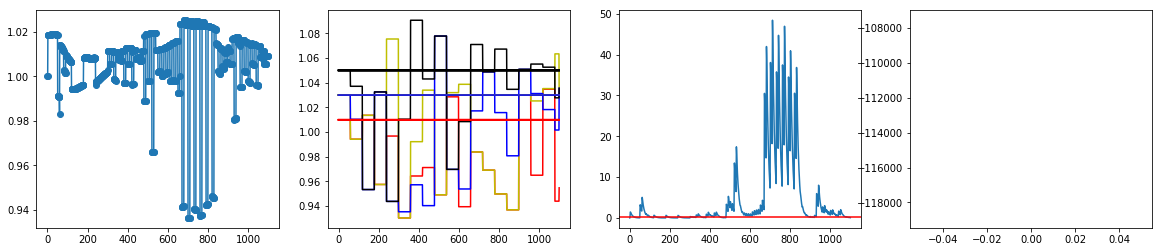

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 1.8719608783721924 seconds ---
--- 0.05382370948791504 seconds ---
--- 0.05585074424743652 seconds ---
--- 0.054822444915771484 seconds ---
--- 0.06482601165771484 seconds ---
--- 0.06183600425720215 seconds ---
--- 0.06881475448608398 seconds ---
-50300.71143166786
--- 46.289154291152954 seconds ---


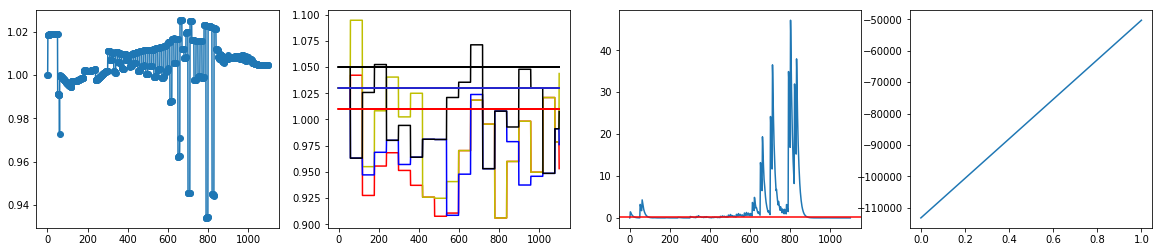

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.0668187141418457 seconds ---
--- 0.06482386589050293 seconds ---
--- 0.0558466911315918 seconds ---
--- 0.06283164024353027 seconds ---
--- 0.05385565757751465 seconds ---
--- 0.05784440040588379 seconds ---
--- 0.06781768798828125 seconds ---
--- 0.06482601165771484 seconds ---
--- 0.055850982666015625 seconds ---
--- 0.06282782554626465 seconds ---
--- 0.06082916259765625 seconds ---
--- 0.07280516624450684 seconds ---
--- 0.05784296989440918 seconds ---
--- 0.0608365535736084 seconds ---
--- 0.07081103324890137 seconds ---
--- 0.06482601165771484 seconds ---
--- 0.06283211708068848 seconds ---
--- 0.06981277465820312 seconds ---
--- 0.0638270378112793 seconds ---
-1317.6984420796784
--- 54.62088346481323 seconds ---


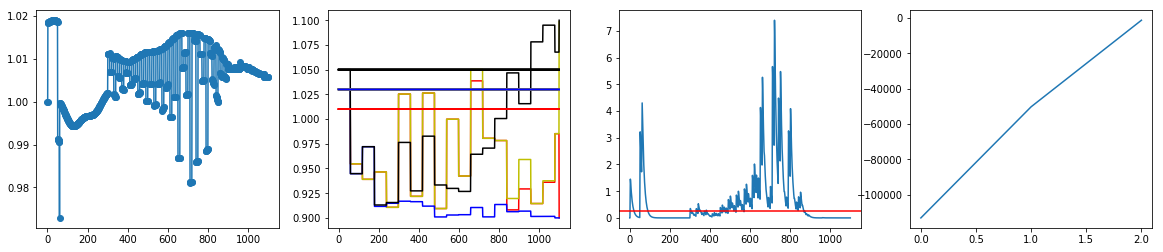

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.06382536888122559 seconds ---
--- 0.0578458309173584 seconds ---
--- 0.06682157516479492 seconds ---
--- 0.05684971809387207 seconds ---
--- 0.06479668617248535 seconds ---
--- 0.05983686447143555 seconds ---
--- 0.056845664978027344 seconds ---
--- 0.05684518814086914 seconds ---
--- 0.059839487075805664 seconds ---
--- 0.06083536148071289 seconds ---
--- 0.05984067916870117 seconds ---
--- 0.06283092498779297 seconds ---
--- 0.061832427978515625 seconds ---
--- 0.06682109832763672 seconds ---
--- 0.059839725494384766 seconds ---
--- 0.05883908271789551 seconds ---
--- 0.06183505058288574 seconds ---
--- 0.060839176177978516 seconds ---
--- 0.06482434272766113 seconds ---
-1317.6984420796784
--- 50.05013036727905 seconds ---


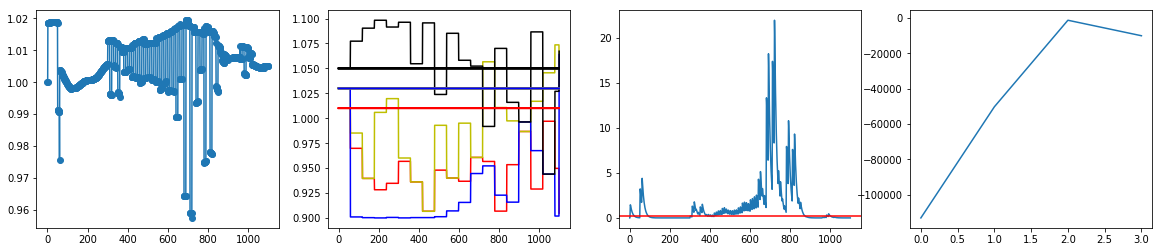

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.06183576583862305 seconds ---
--- 0.060837507247924805 seconds ---
--- 0.06083798408508301 seconds ---
--- 0.06981134414672852 seconds ---
--- 0.06282973289489746 seconds ---
--- 0.06682062149047852 seconds ---
--- 0.0668175220489502 seconds ---
--- 0.05983757972717285 seconds ---
--- 0.06680774688720703 seconds ---
--- 0.05485248565673828 seconds ---
--- 0.05584836006164551 seconds ---
--- 0.0608372688293457 seconds ---
--- 0.05784034729003906 seconds ---
--- 0.06482434272766113 seconds ---
--- 0.06881427764892578 seconds ---
--- 0.06582140922546387 seconds ---
--- 0.06582427024841309 seconds ---
--- 0.0578458309173584 seconds ---
--- 0.0608370304107666 seconds ---
-1317.6984420796784
--- 50.32437992095947 seconds ---


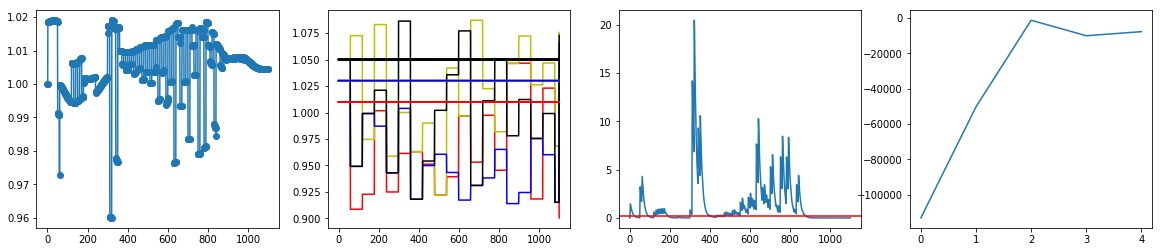

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.07180619239807129 seconds ---
--- 0.06582355499267578 seconds ---
--- 0.07878398895263672 seconds ---
--- 0.06881546974182129 seconds ---
--- 0.06582283973693848 seconds ---
--- 0.05584907531738281 seconds ---
--- 0.05984044075012207 seconds ---
--- 0.07479691505432129 seconds ---
--- 0.07878780364990234 seconds ---
--- 0.06582283973693848 seconds ---
--- 0.05784344673156738 seconds ---
--- 0.06482505798339844 seconds ---
--- 0.06482553482055664 seconds ---
--- 0.06183457374572754 seconds ---
--- 0.07779169082641602 seconds ---
--- 0.06183290481567383 seconds ---
--- 0.05684804916381836 seconds ---
--- 0.060837507247924805 seconds ---
--- 0.060837507247924805 seconds ---
-1317.6984420796784
--- 55.243221044540405 seconds ---


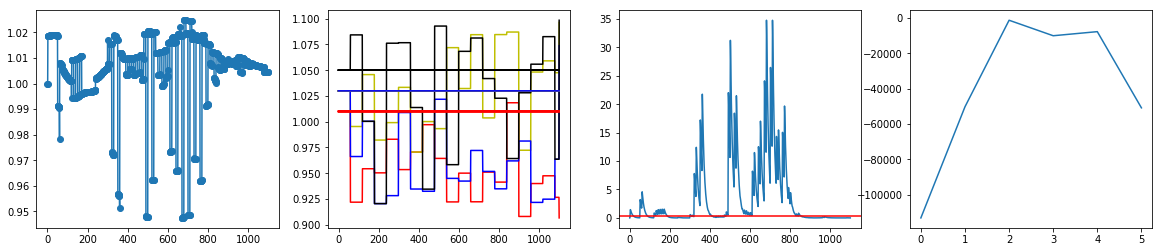

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.06881570816040039 seconds ---
--- 0.06781268119812012 seconds ---
--- 0.06582379341125488 seconds ---
--- 0.06582450866699219 seconds ---
--- 0.06880855560302734 seconds ---
--- 0.060837507247924805 seconds ---
--- 0.06482505798339844 seconds ---
--- 0.060837745666503906 seconds ---
--- 0.06283020973205566 seconds ---
--- 0.05684709548950195 seconds ---
--- 0.0578455924987793 seconds ---
--- 0.059832096099853516 seconds ---
--- 0.06283068656921387 seconds ---
--- 0.05584859848022461 seconds ---
--- 0.07081007957458496 seconds ---
--- 0.06183314323425293 seconds ---
--- 0.06482696533203125 seconds ---
--- 0.05883431434631348 seconds ---
--- 0.07280373573303223 seconds ---
-1317.6984420796784
--- 52.28912377357483 seconds ---


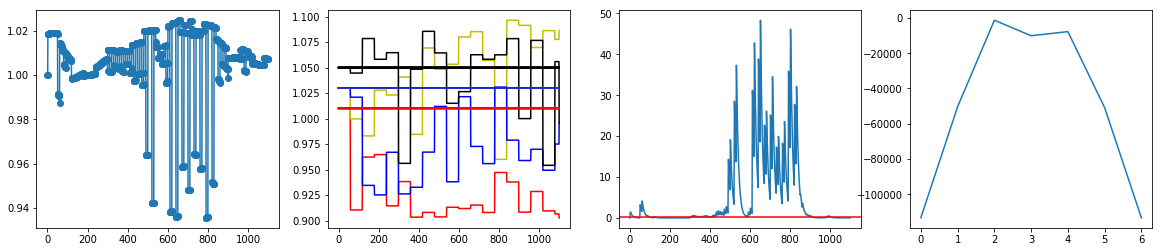

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.06581544876098633 seconds ---
--- 0.07579684257507324 seconds ---
--- 0.056848764419555664 seconds ---
--- 0.06083488464355469 seconds ---
--- 0.061833858489990234 seconds ---
--- 0.060835838317871094 seconds ---
--- 0.05585169792175293 seconds ---
--- 0.05584716796875 seconds ---
--- 0.06283068656921387 seconds ---
--- 0.06283044815063477 seconds ---
--- 0.06582522392272949 seconds ---
--- 0.0638277530670166 seconds ---
--- 0.05485057830810547 seconds ---
--- 0.05585050582885742 seconds ---
--- 0.0638267993927002 seconds ---
--- 0.05784416198730469 seconds ---
--- 0.05584859848022461 seconds ---
--- 0.06283211708068848 seconds ---
--- 0.06682062149047852 seconds ---
-1317.6984420796784
--- 49.33997821807861 seconds ---


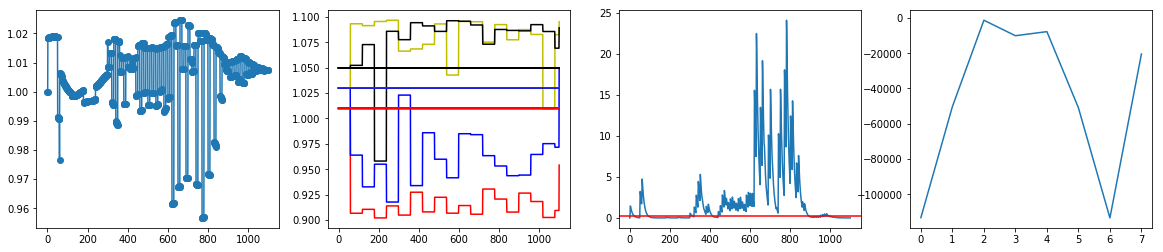

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.059838294982910156 seconds ---
--- 0.06183195114135742 seconds ---
--- 0.06582069396972656 seconds ---
--- 0.05983996391296387 seconds ---
--- 0.06682205200195312 seconds ---
--- 0.0638265609741211 seconds ---
--- 0.06482386589050293 seconds ---
--- 0.0608370304107666 seconds ---
--- 0.06283044815063477 seconds ---
--- 0.06582307815551758 seconds ---
--- 0.06579375267028809 seconds ---
--- 0.05983877182006836 seconds ---
--- 0.0668189525604248 seconds ---
--- 0.060837507247924805 seconds ---
--- 0.05884218215942383 seconds ---
--- 0.06482648849487305 seconds ---
--- 0.07080984115600586 seconds ---
--- 0.05983686447143555 seconds ---
--- 0.06183266639709473 seconds ---
-1317.6984420796784
--- 44.83206844329834 seconds ---


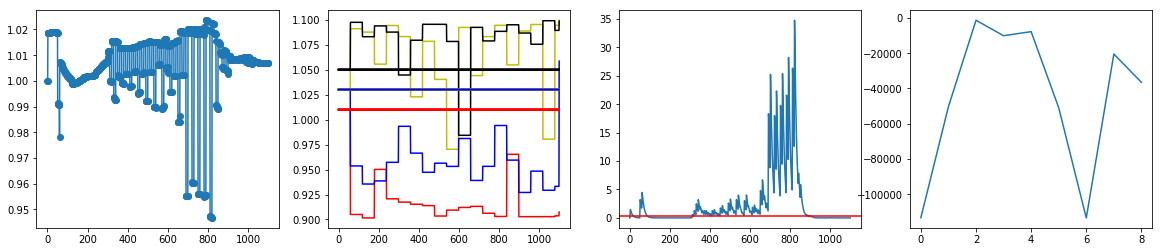

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.06781721115112305 seconds ---
--- 0.06083798408508301 seconds ---
--- 0.07380223274230957 seconds ---
--- 0.07081103324890137 seconds ---
--- 0.07779097557067871 seconds ---
--- 0.06282782554626465 seconds ---
--- 0.07379841804504395 seconds ---
--- 0.07280302047729492 seconds ---
--- 0.0698087215423584 seconds ---
--- 0.06682133674621582 seconds ---
--- 0.06582260131835938 seconds ---
--- 0.06881308555603027 seconds ---
--- 0.07579374313354492 seconds ---
--- 0.0638279914855957 seconds ---
--- 0.059839487075805664 seconds ---
--- 0.05884122848510742 seconds ---
--- 0.061833858489990234 seconds ---
--- 0.10471844673156738 seconds ---
--- 0.07081103324890137 seconds ---
-1317.6984420796784
--- 60.8841290473938 seconds ---


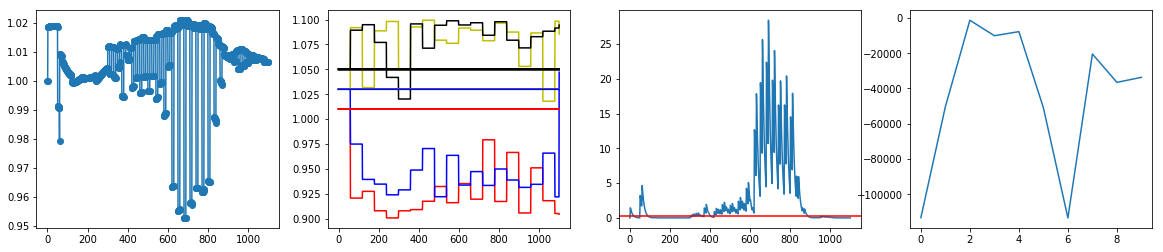

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.07579803466796875 seconds ---
--- 0.06881523132324219 seconds ---
--- 0.06781697273254395 seconds ---
--- 0.07280111312866211 seconds ---
--- 0.07080841064453125 seconds ---
--- 0.05983877182006836 seconds ---
--- 0.06681609153747559 seconds ---
--- 0.06482601165771484 seconds ---
--- 0.06183433532714844 seconds ---
--- 0.06482434272766113 seconds ---
--- 0.07380223274230957 seconds ---
--- 0.07679271697998047 seconds ---
--- 0.07080984115600586 seconds ---
--- 0.08078265190124512 seconds ---
--- 0.07380318641662598 seconds ---
--- 0.06083798408508301 seconds ---
--- 0.06283187866210938 seconds ---
--- 0.06682133674621582 seconds ---
--- 0.06382918357849121 seconds ---
-1317.6984420796784
--- 54.561046838760376 seconds ---


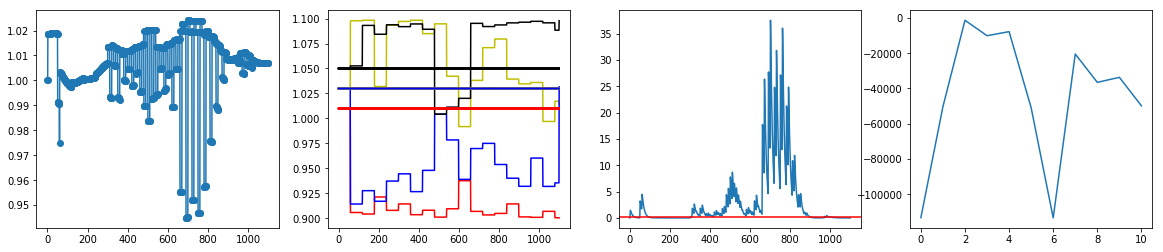

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.0668191909790039 seconds ---
--- 0.07080984115600586 seconds ---
--- 0.05984067916870117 seconds ---
--- 0.06681704521179199 seconds ---
--- 0.05884146690368652 seconds ---
--- 0.059838056564331055 seconds ---
--- 0.0668189525604248 seconds ---
--- 0.05884242057800293 seconds ---
--- 0.06183362007141113 seconds ---
--- 0.05585026741027832 seconds ---
--- 0.06282949447631836 seconds ---
--- 0.0688166618347168 seconds ---
--- 0.05684661865234375 seconds ---
--- 0.06482720375061035 seconds ---
--- 0.06981253623962402 seconds ---
--- 0.0618288516998291 seconds ---
--- 0.05983924865722656 seconds ---
--- 0.06582283973693848 seconds ---
--- 0.06682014465332031 seconds ---
-1317.6984420796784
--- 50.088008642196655 seconds ---


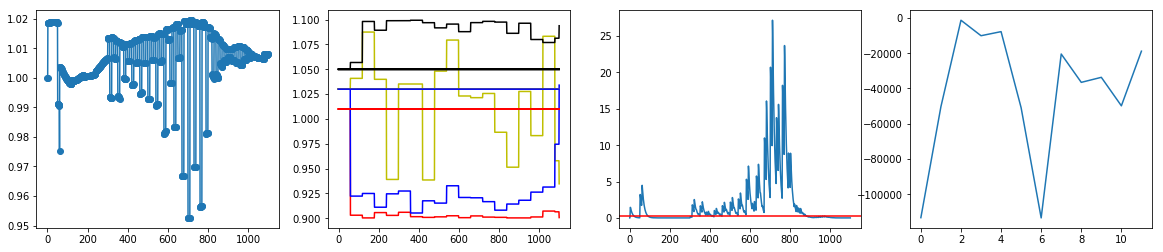

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.05983877182006836 seconds ---
--- 0.055849552154541016 seconds ---
--- 0.07280516624450684 seconds ---
--- 0.059839487075805664 seconds ---
--- 0.06781697273254395 seconds ---
--- 0.05884122848510742 seconds ---
--- 0.06582450866699219 seconds ---
--- 0.06881237030029297 seconds ---
--- 0.055850982666015625 seconds ---
--- 0.05980873107910156 seconds ---
--- 0.06682133674621582 seconds ---
--- 0.06981444358825684 seconds ---
--- 0.05485200881958008 seconds ---
--- 0.0578463077545166 seconds ---
--- 0.06183362007141113 seconds ---
--- 0.06382083892822266 seconds ---
--- 0.08277630805969238 seconds ---
--- 0.060837507247924805 seconds ---
--- 0.06682157516479492 seconds ---
-1317.6984420796784
--- 54.70964741706848 seconds ---


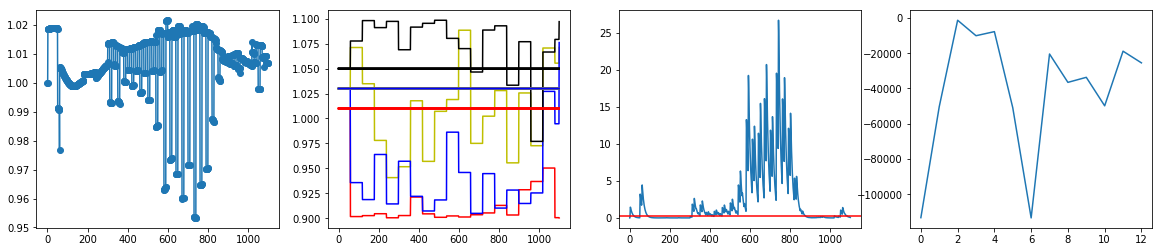

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.05983924865722656 seconds ---
--- 0.06482458114624023 seconds ---
--- 0.057843685150146484 seconds ---
--- 0.06681966781616211 seconds ---
--- 0.06682109832763672 seconds ---
--- 0.060835838317871094 seconds ---
--- 0.07180476188659668 seconds ---
--- 0.06881523132324219 seconds ---
--- 0.06183505058288574 seconds ---
--- 0.07579636573791504 seconds ---
--- 0.0638272762298584 seconds ---
--- 0.0638275146484375 seconds ---
--- 0.060836076736450195 seconds ---
--- 0.07678961753845215 seconds ---
--- 0.0638279914855957 seconds ---
--- 0.0638282299041748 seconds ---
--- 0.07280087471008301 seconds ---
--- 0.05784463882446289 seconds ---
--- 0.06482625007629395 seconds ---
-1317.6984420796784
--- 57.82830572128296 seconds ---


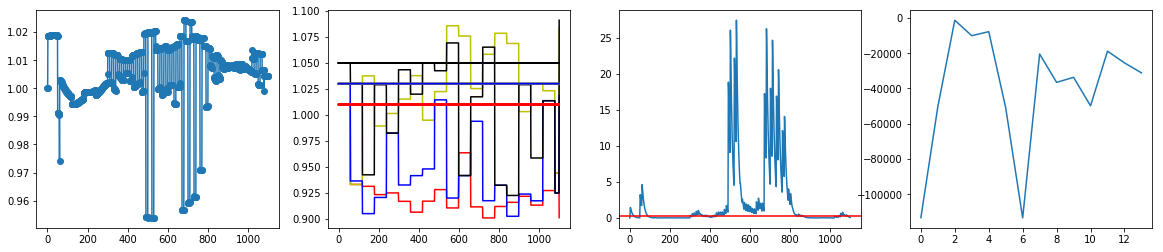

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.06881546974182129 seconds ---
--- 0.07479548454284668 seconds ---
--- 0.06781625747680664 seconds ---
--- 0.06781911849975586 seconds ---
--- 0.05784487724304199 seconds ---
--- 0.07080984115600586 seconds ---
--- 0.06981301307678223 seconds ---
--- 0.07878851890563965 seconds ---
--- 0.060837507247924805 seconds ---
--- 0.07280421257019043 seconds ---
--- 0.06383109092712402 seconds ---
--- 0.07280516624450684 seconds ---
--- 0.0638277530670166 seconds ---
--- 0.0747992992401123 seconds ---
--- 0.06781959533691406 seconds ---
--- 0.05784463882446289 seconds ---
--- 0.07679367065429688 seconds ---
--- 0.06881523132324219 seconds ---
--- 0.06981205940246582 seconds ---
-1317.6984420796784
--- 58.92536950111389 seconds ---


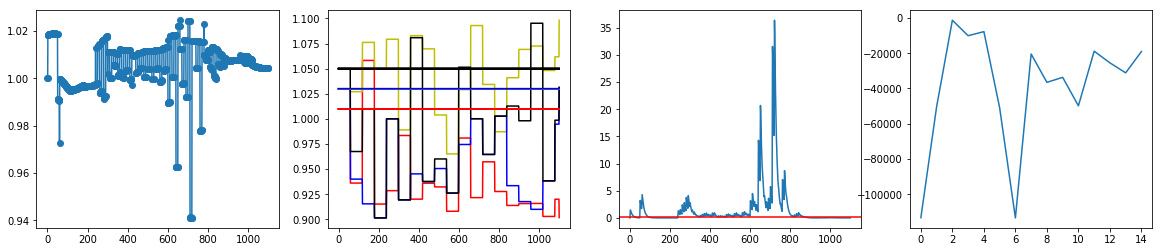

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.0728003978729248 seconds ---
--- 0.07878708839416504 seconds ---
--- 0.07579278945922852 seconds ---
--- 0.07280540466308594 seconds ---
--- 0.07080721855163574 seconds ---
--- 0.06382608413696289 seconds ---
--- 0.0718083381652832 seconds ---
--- 0.060837507247924805 seconds ---
--- 0.06781840324401855 seconds ---
--- 0.07280349731445312 seconds ---
--- 0.07080769538879395 seconds ---
--- 0.07779049873352051 seconds ---
--- 0.08676600456237793 seconds ---
--- 0.07579517364501953 seconds ---
--- 0.07579779624938965 seconds ---
--- 0.06781840324401855 seconds ---
--- 0.06781601905822754 seconds ---
--- 0.07978343963623047 seconds ---
--- 0.06881356239318848 seconds ---
-1317.6984420796784
--- 57.61088514328003 seconds ---


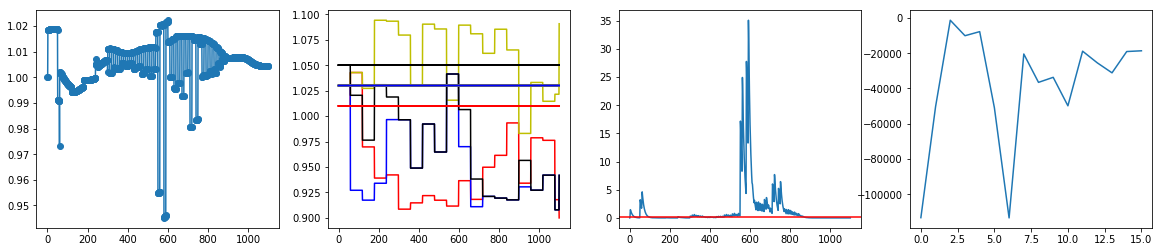

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.06781506538391113 seconds ---
--- 0.0718080997467041 seconds ---
--- 0.07380080223083496 seconds ---
--- 0.0638275146484375 seconds ---
--- 0.07878756523132324 seconds ---
--- 0.06582379341125488 seconds ---
--- 0.0698099136352539 seconds ---
--- 0.06881546974182129 seconds ---
--- 0.06881475448608398 seconds ---
--- 0.06981158256530762 seconds ---
--- 0.0698096752166748 seconds ---
--- 0.06981134414672852 seconds ---
--- 0.06482601165771484 seconds ---
--- 0.059838294982910156 seconds ---
--- 0.05883479118347168 seconds ---
--- 0.07480001449584961 seconds ---
--- 0.0638284683227539 seconds ---
--- 0.05784487724304199 seconds ---
--- 0.07280516624450684 seconds ---
-1226.8858725777136
--- 57.26381492614746 seconds ---


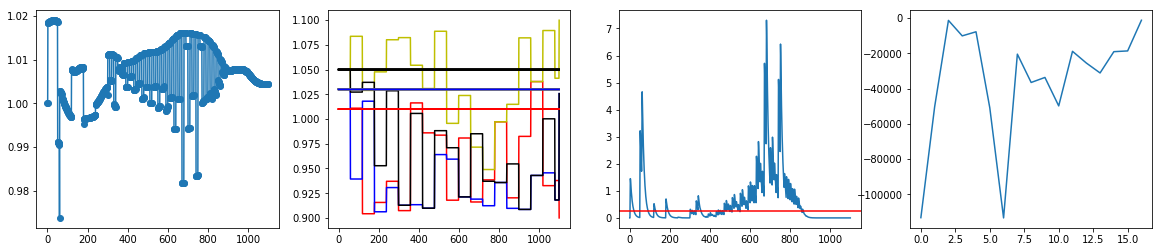

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.07280635833740234 seconds ---
--- 0.07878923416137695 seconds ---
--- 0.07679319381713867 seconds ---
--- 0.06283211708068848 seconds ---
--- 0.07279825210571289 seconds ---
--- 0.07280445098876953 seconds ---
--- 0.07379651069641113 seconds ---
--- 0.07380032539367676 seconds ---
--- 0.07380032539367676 seconds ---
--- 0.07280325889587402 seconds ---
--- 0.0718080997467041 seconds ---
--- 0.06083798408508301 seconds ---
--- 0.07679200172424316 seconds ---
--- 0.07280254364013672 seconds ---
--- 0.06183433532714844 seconds ---
--- 0.06382608413696289 seconds ---
--- 0.06781554222106934 seconds ---
--- 0.06582450866699219 seconds ---
--- 0.07480072975158691 seconds ---
-1226.8858725777136
--- 59.01313304901123 seconds ---


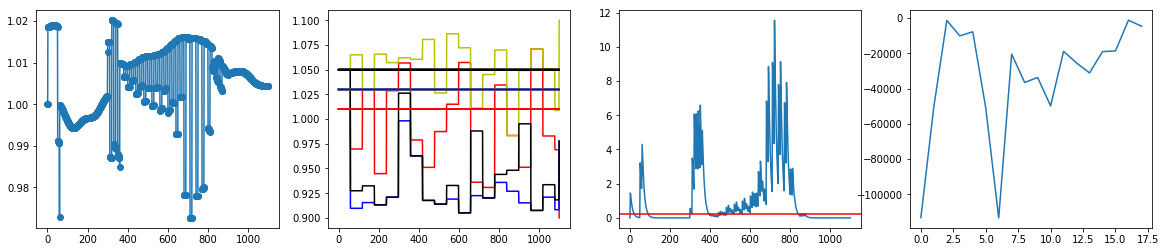

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.07380032539367676 seconds ---
--- 0.06781888008117676 seconds ---
--- 0.06382894515991211 seconds ---
--- 0.0747983455657959 seconds ---
--- 0.05977892875671387 seconds ---
--- 0.07679057121276855 seconds ---
--- 0.06382346153259277 seconds ---
--- 0.07080817222595215 seconds ---
--- 0.06781959533691406 seconds ---
--- 0.06682085990905762 seconds ---
--- 0.07679367065429688 seconds ---
--- 0.06283068656921387 seconds ---
--- 0.06781649589538574 seconds ---
--- 0.057840824127197266 seconds ---
--- 0.07081055641174316 seconds ---
--- 0.07080984115600586 seconds ---
--- 0.07878732681274414 seconds ---
--- 0.06881594657897949 seconds ---
--- 0.07579612731933594 seconds ---
-1226.8858725777136
--- 64.77073240280151 seconds ---


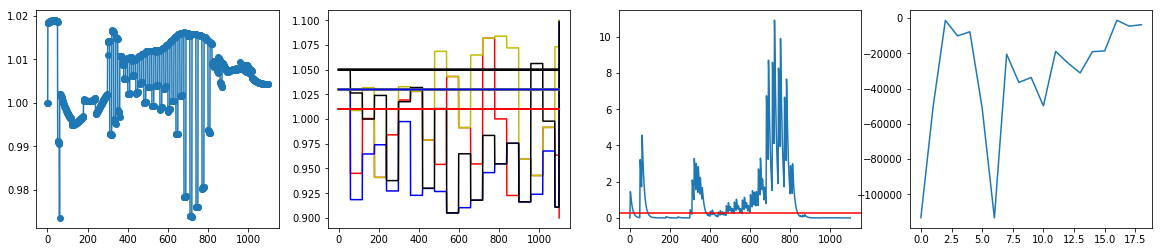

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.07479643821716309 seconds ---
--- 0.07380151748657227 seconds ---
--- 0.07579684257507324 seconds ---
--- 0.07878756523132324 seconds ---
--- 0.07380223274230957 seconds ---
--- 0.05784296989440918 seconds ---
--- 0.06382918357849121 seconds ---
--- 0.06781792640686035 seconds ---
--- 0.07779169082641602 seconds ---
--- 0.061833858489990234 seconds ---
--- 0.08177971839904785 seconds ---
--- 0.05884242057800293 seconds ---
--- 0.06282973289489746 seconds ---
--- 0.07380127906799316 seconds ---
--- 0.07878732681274414 seconds ---
--- 0.05784440040588379 seconds ---
--- 0.06781768798828125 seconds ---
--- 0.07978534698486328 seconds ---
--- 0.06283020973205566 seconds ---
-1226.8858725777136
--- 65.83887577056885 seconds ---


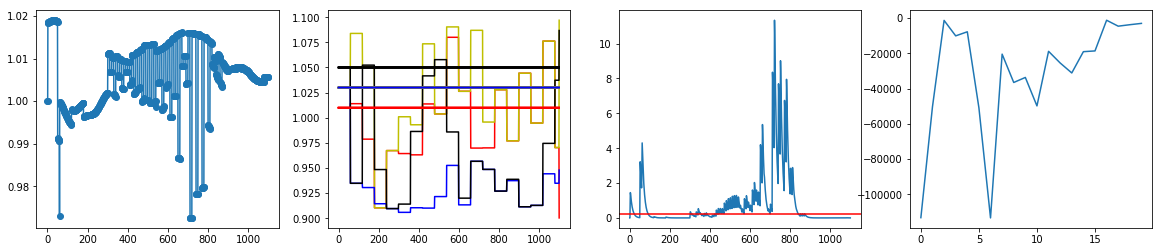

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.05984044075012207 seconds ---
--- 0.07380080223083496 seconds ---
--- 0.07080912590026855 seconds ---
--- 0.07280373573303223 seconds ---
--- 0.07579588890075684 seconds ---
--- 0.06282734870910645 seconds ---
--- 0.0688169002532959 seconds ---
--- 0.07678961753845215 seconds ---
--- 0.0688164234161377 seconds ---
--- 0.06781840324401855 seconds ---
--- 0.07480001449584961 seconds ---
--- 0.06582236289978027 seconds ---
--- 0.07180523872375488 seconds ---
--- 0.059839725494384766 seconds ---
--- 0.06283164024353027 seconds ---
--- 0.06282949447631836 seconds ---
--- 0.06482744216918945 seconds ---
--- 0.0638279914855957 seconds ---
--- 0.06283044815063477 seconds ---
-1226.8858725777136
--- 61.44961643218994 seconds ---


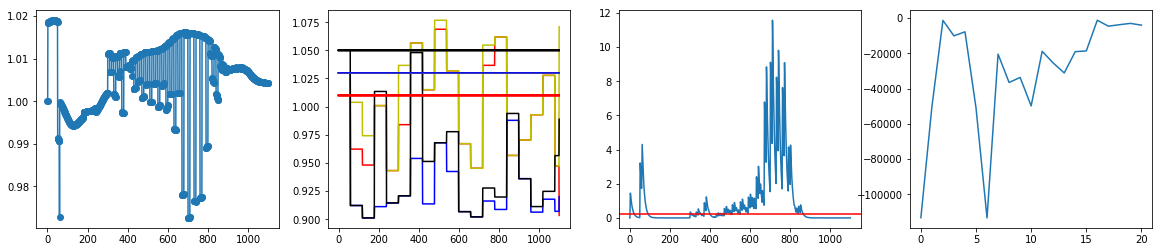

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.0747995376586914 seconds ---
--- 0.06981158256530762 seconds ---
--- 0.0747983455657959 seconds ---
--- 0.06781721115112305 seconds ---
--- 0.059838294982910156 seconds ---
--- 0.06981348991394043 seconds ---
--- 0.07280206680297852 seconds ---
--- 0.08078408241271973 seconds ---
--- 0.06582283973693848 seconds ---
--- 0.06781721115112305 seconds ---
--- 0.06283092498779297 seconds ---
--- 0.06881260871887207 seconds ---
--- 0.06183433532714844 seconds ---
--- 0.08078360557556152 seconds ---
--- 0.08377623558044434 seconds ---
--- 0.0638275146484375 seconds ---
--- 0.0698087215423584 seconds ---
--- 0.06183362007141113 seconds ---
--- 0.0638279914855957 seconds ---
-1226.8858725777136
--- 63.045347452163696 seconds ---


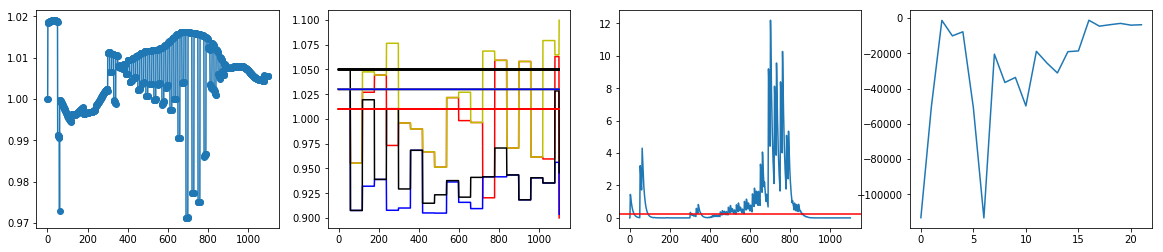

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.07180500030517578 seconds ---
--- 0.06880784034729004 seconds ---
--- 0.06682157516479492 seconds ---
--- 0.08177995681762695 seconds ---
--- 0.07380151748657227 seconds ---
--- 0.06582236289978027 seconds ---
--- 0.0688161849975586 seconds ---
--- 0.0608372688293457 seconds ---
--- 0.07080912590026855 seconds ---
--- 0.060834646224975586 seconds ---
--- 0.05784487724304199 seconds ---
--- 0.07779073715209961 seconds ---
--- 0.06482458114624023 seconds ---
--- 0.07081031799316406 seconds ---
--- 0.07380366325378418 seconds ---
--- 0.06482434272766113 seconds ---
--- 0.05584979057312012 seconds ---
--- 0.06781864166259766 seconds ---
--- 0.0718076229095459 seconds ---
-628.1411654619775
--- 57.10025072097778 seconds ---


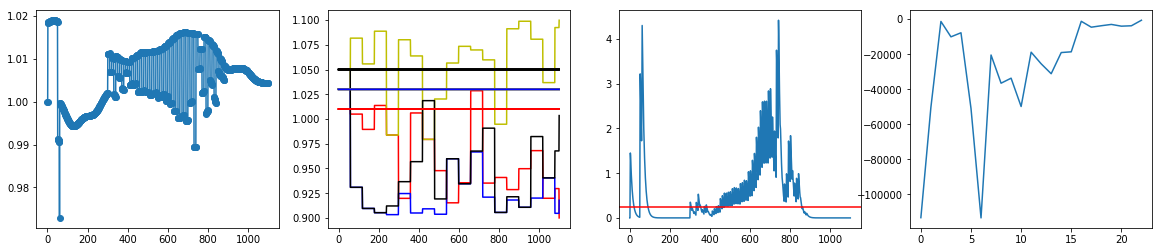

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.0747978687286377 seconds ---
--- 0.06282854080200195 seconds ---
--- 0.0698094367980957 seconds ---
--- 0.07080817222595215 seconds ---
--- 0.07080960273742676 seconds ---
--- 0.08177804946899414 seconds ---
--- 0.08178138732910156 seconds ---
--- 0.0747992992401123 seconds ---
--- 0.06482648849487305 seconds ---
--- 0.07080864906311035 seconds ---
--- 0.07280516624450684 seconds ---
--- 0.07679438591003418 seconds ---
--- 0.07779216766357422 seconds ---
--- 0.05884242057800293 seconds ---
--- 0.07679247856140137 seconds ---
--- 0.0718069076538086 seconds ---
--- 0.06482315063476562 seconds ---
--- 0.07480072975158691 seconds ---
--- 0.06083536148071289 seconds ---
-628.1411654619775
--- 60.14211320877075 seconds ---


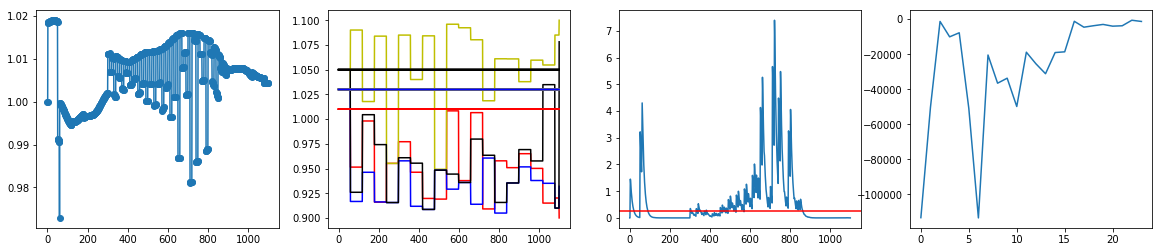

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.07280135154724121 seconds ---
--- 0.07579684257507324 seconds ---
--- 0.06781673431396484 seconds ---
--- 0.06682038307189941 seconds ---
--- 0.08477210998535156 seconds ---
--- 0.0747995376586914 seconds ---
--- 0.07081079483032227 seconds ---
--- 0.07080960273742676 seconds ---
--- 0.058844804763793945 seconds ---
--- 0.07080960273742676 seconds ---
--- 0.07878923416137695 seconds ---
--- 0.0638279914855957 seconds ---
--- 0.06582403182983398 seconds ---
--- 0.06781744956970215 seconds ---
--- 0.07080912590026855 seconds ---
--- 0.06382632255554199 seconds ---
--- 0.07280492782592773 seconds ---
--- 0.07280492782592773 seconds ---
--- 0.074798583984375 seconds ---
-628.1411654619775
--- 61.18831658363342 seconds ---


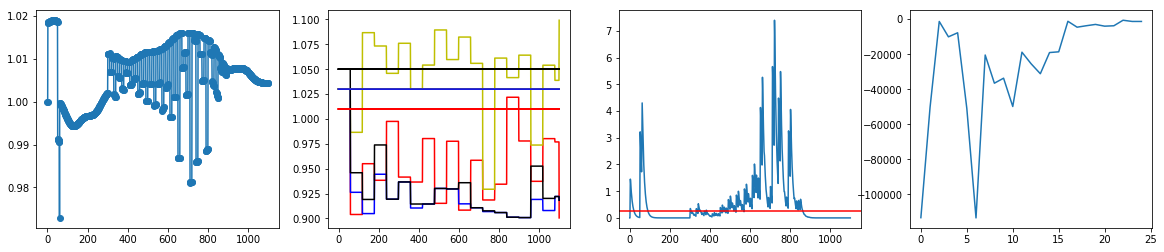

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.08477377891540527 seconds ---
--- 0.07679438591003418 seconds ---
--- 0.06582283973693848 seconds ---
--- 0.06582427024841309 seconds ---
--- 0.0638277530670166 seconds ---
--- 0.07679462432861328 seconds ---
--- 0.05983781814575195 seconds ---
--- 0.07080864906311035 seconds ---
--- 0.07280254364013672 seconds ---
--- 0.06482577323913574 seconds ---
--- 0.06582379341125488 seconds ---
--- 0.07180500030517578 seconds ---
--- 0.06981182098388672 seconds ---
--- 0.06981015205383301 seconds ---
--- 0.06881427764892578 seconds ---
--- 0.05983877182006836 seconds ---
--- 0.06682062149047852 seconds ---
--- 0.06981253623962402 seconds ---
--- 0.07380175590515137 seconds ---
-628.1411654619775
--- 60.99682950973511 seconds ---


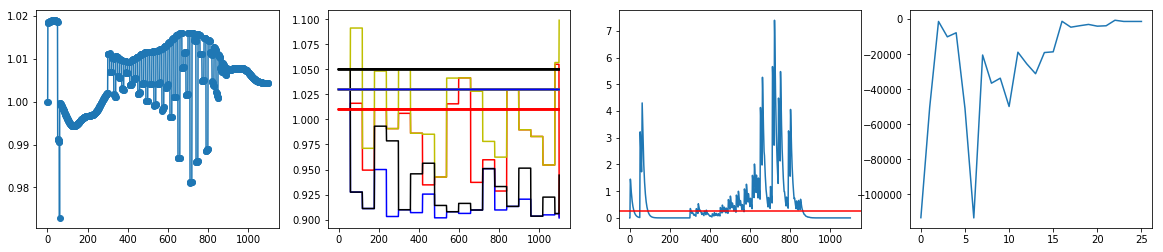

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.07479977607727051 seconds ---
--- 0.08477592468261719 seconds ---
--- 0.06382966041564941 seconds ---
--- 0.061833858489990234 seconds ---
--- 0.06482553482055664 seconds ---
--- 0.06981253623962402 seconds ---
--- 0.07379889488220215 seconds ---
--- 0.07081031799316406 seconds ---
--- 0.057843923568725586 seconds ---
--- 0.06482601165771484 seconds ---
--- 0.06482625007629395 seconds ---
--- 0.07579803466796875 seconds ---
--- 0.07380104064941406 seconds ---
--- 0.07679367065429688 seconds ---
--- 0.05784273147583008 seconds ---
--- 0.06283211708068848 seconds ---
--- 0.07579636573791504 seconds ---
--- 0.06981253623962402 seconds ---
--- 0.06283092498779297 seconds ---
-628.1411654619775
--- 61.25513744354248 seconds ---


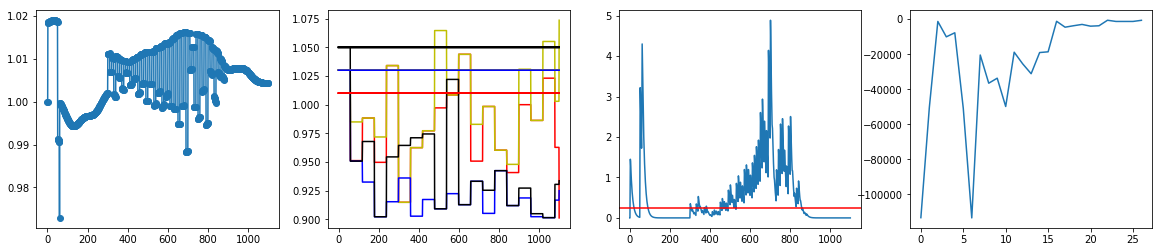

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.06582117080688477 seconds ---
--- 0.06881427764892578 seconds ---
--- 0.058843135833740234 seconds ---
--- 0.07080960273742676 seconds ---
--- 0.07280731201171875 seconds ---
--- 0.06482672691345215 seconds ---
--- 0.06382346153259277 seconds ---
--- 0.06083822250366211 seconds ---
--- 0.07479977607727051 seconds ---
--- 0.07081151008605957 seconds ---
--- 0.07878851890563965 seconds ---
--- 0.0807797908782959 seconds ---
--- 0.06981134414672852 seconds ---
--- 0.06781721115112305 seconds ---
--- 0.07379984855651855 seconds ---
--- 0.07779121398925781 seconds ---
--- 0.08078336715698242 seconds ---
--- 0.07878875732421875 seconds ---
--- 0.06582164764404297 seconds ---
-628.1411654619775
--- 60.27176880836487 seconds ---


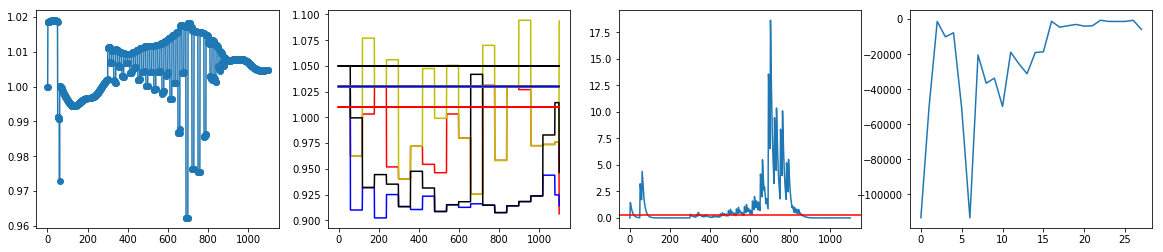

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.07380127906799316 seconds ---
--- 0.07380032539367676 seconds ---
--- 0.06283164024353027 seconds ---
--- 0.07080912590026855 seconds ---
--- 0.05784487724304199 seconds ---
--- 0.07380151748657227 seconds ---
--- 0.06981372833251953 seconds ---
--- 0.08277535438537598 seconds ---
--- 0.05983924865722656 seconds ---
--- 0.09374690055847168 seconds ---
--- 0.06582236289978027 seconds ---
--- 0.060835838317871094 seconds ---
--- 0.07579731941223145 seconds ---
--- 0.0747983455657959 seconds ---
--- 0.07579612731933594 seconds ---
--- 0.07579684257507324 seconds ---
--- 0.0747988224029541 seconds ---
--- 0.07180595397949219 seconds ---
--- 0.0608372688293457 seconds ---
-628.1411654619775
--- 62.42101716995239 seconds ---


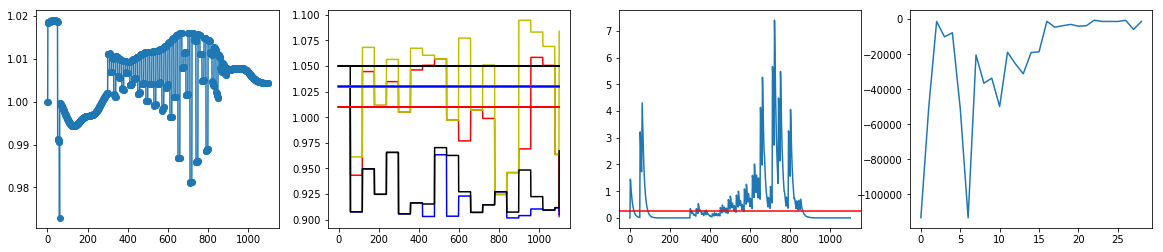

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.06981182098388672 seconds ---
--- 0.05884265899658203 seconds ---
--- 0.06482386589050293 seconds ---
--- 0.06781768798828125 seconds ---
--- 0.06881237030029297 seconds ---
--- 0.06781864166259766 seconds ---
--- 0.07280278205871582 seconds ---
--- 0.07080984115600586 seconds ---
--- 0.06183338165283203 seconds ---
--- 0.06881546974182129 seconds ---
--- 0.05784463882446289 seconds ---
--- 0.08377194404602051 seconds ---
--- 0.0718073844909668 seconds ---
--- 0.06482720375061035 seconds ---
--- 0.07080984115600586 seconds ---
--- 0.06083869934082031 seconds ---
--- 0.06282949447631836 seconds ---
--- 0.06382894515991211 seconds ---
--- 0.07380056381225586 seconds ---
-628.1411654619775
--- 59.39212131500244 seconds ---


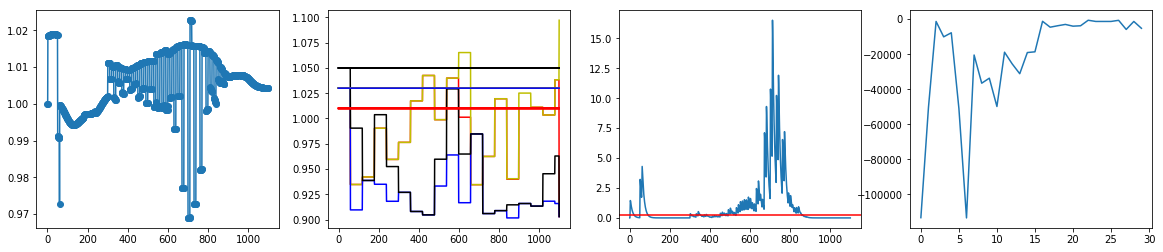

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.07579708099365234 seconds ---
--- 0.07081055641174316 seconds ---
--- 0.06682062149047852 seconds ---
--- 0.06781578063964844 seconds ---
--- 0.0718073844909668 seconds ---
--- 0.06382894515991211 seconds ---
--- 0.07380223274230957 seconds ---
--- 0.05784201622009277 seconds ---
--- 0.07080984115600586 seconds ---
--- 0.07779049873352051 seconds ---
--- 0.07679510116577148 seconds ---
--- 0.0688164234161377 seconds ---
--- 0.06183147430419922 seconds ---
--- 0.07180619239807129 seconds ---
--- 0.06283092498779297 seconds ---
--- 0.07579708099365234 seconds ---
--- 0.07280540466308594 seconds ---
--- 0.07978439331054688 seconds ---
--- 0.06981229782104492 seconds ---
-628.1411654619775
--- 60.64677166938782 seconds ---


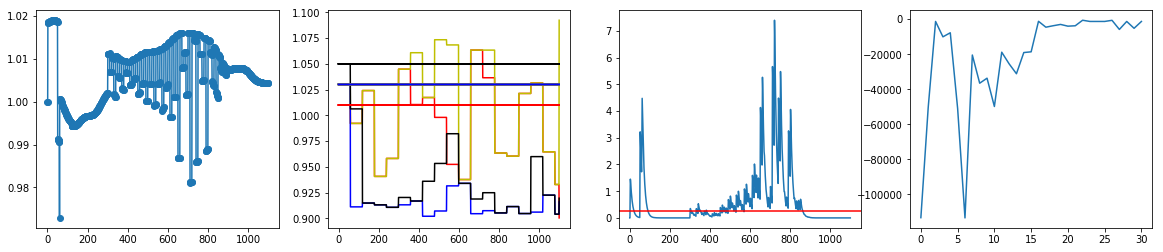

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.07080721855163574 seconds ---
--- 0.06981301307678223 seconds ---
--- 0.059839487075805664 seconds ---
--- 0.0777902603149414 seconds ---
--- 0.06382870674133301 seconds ---
--- 0.0747976303100586 seconds ---
--- 0.05784177780151367 seconds ---
--- 0.10172796249389648 seconds ---
--- 0.07480144500732422 seconds ---
--- 0.06781625747680664 seconds ---
--- 0.06382918357849121 seconds ---
--- 0.06482315063476562 seconds ---
--- 0.0668189525604248 seconds ---
--- 0.0747983455657959 seconds ---
--- 0.06582236289978027 seconds ---
--- 0.07380104064941406 seconds ---
--- 0.06582355499267578 seconds ---
--- 0.06582379341125488 seconds ---
--- 0.07679438591003418 seconds ---
-628.1411654619775
--- 60.114187479019165 seconds ---


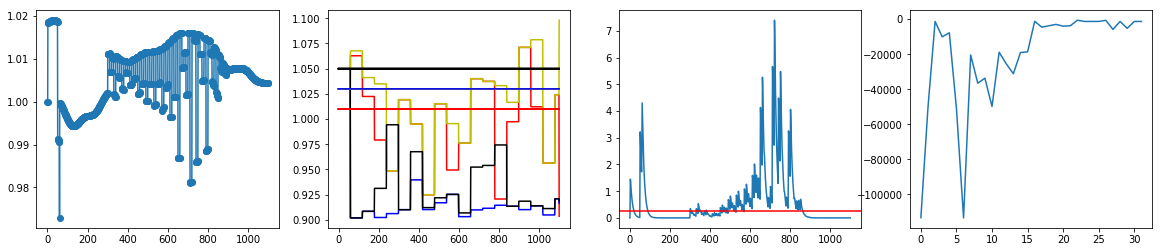

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.07480001449584961 seconds ---
--- 0.06981253623962402 seconds ---
--- 0.06283164024353027 seconds ---
--- 0.07280373573303223 seconds ---
--- 0.0718073844909668 seconds ---
--- 0.07579302787780762 seconds ---
--- 0.1027224063873291 seconds ---
--- 0.10471796989440918 seconds ---
--- 0.0608365535736084 seconds ---
--- 0.08078312873840332 seconds ---
--- 0.060834646224975586 seconds ---
--- 0.07280445098876953 seconds ---
--- 0.07679438591003418 seconds ---
--- 0.06482458114624023 seconds ---
--- 0.06482577323913574 seconds ---
--- 0.06382918357849121 seconds ---
--- 0.07978653907775879 seconds ---
--- 0.10471916198730469 seconds ---
--- 0.06582164764404297 seconds ---
-628.1411654619775
--- 61.17935061454773 seconds ---


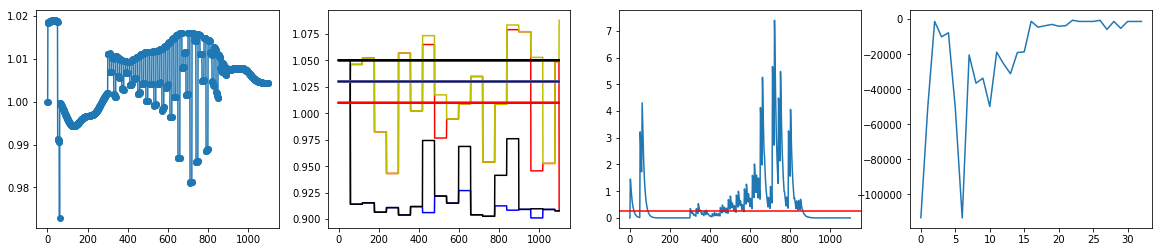

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.057843923568725586 seconds ---
--- 0.06781744956970215 seconds ---
--- 0.06881451606750488 seconds ---
--- 0.06881523132324219 seconds ---
--- 0.06981086730957031 seconds ---
--- 0.06283164024353027 seconds ---
--- 0.07280516624450684 seconds ---
--- 0.06482648849487305 seconds ---
--- 0.06183314323425293 seconds ---
--- 0.05684614181518555 seconds ---
--- 0.06981229782104492 seconds ---
--- 0.06183362007141113 seconds ---
--- 0.06482601165771484 seconds ---
--- 0.07379913330078125 seconds ---
--- 0.06582164764404297 seconds ---
--- 0.074798583984375 seconds ---
--- 0.06582260131835938 seconds ---
--- 0.0668184757232666 seconds ---
--- 0.06881451606750488 seconds ---
-628.1411654619775
--- 60.36850833892822 seconds ---


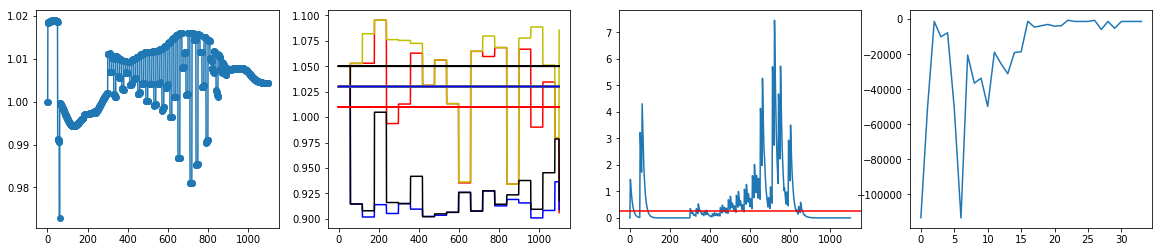

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.07779097557067871 seconds ---
--- 0.06781959533691406 seconds ---
--- 0.06981325149536133 seconds ---
--- 0.0718069076538086 seconds ---
--- 0.06183481216430664 seconds ---
--- 0.07978439331054688 seconds ---
--- 0.07579588890075684 seconds ---
--- 0.06183457374572754 seconds ---
--- 0.06382942199707031 seconds ---
--- 0.07480025291442871 seconds ---
--- 0.0718069076538086 seconds ---
--- 0.07579517364501953 seconds ---
--- 0.06881451606750488 seconds ---
--- 0.07380127906799316 seconds ---
--- 0.05784320831298828 seconds ---
--- 0.06881546974182129 seconds ---
--- 0.05983901023864746 seconds ---
--- 0.05684781074523926 seconds ---
--- 0.06881546974182129 seconds ---
-628.1411654619775
--- 60.83027362823486 seconds ---


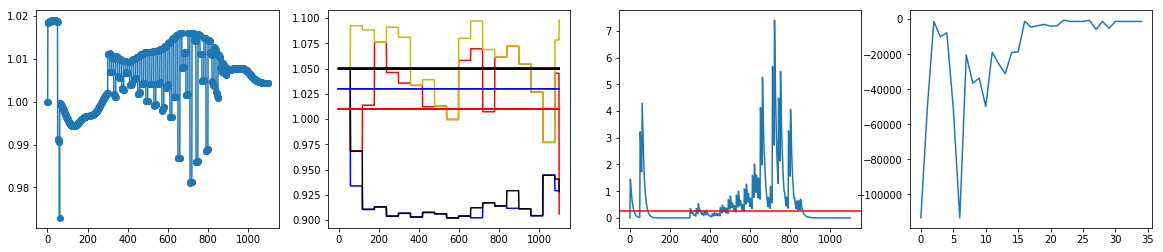

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.0777895450592041 seconds ---
--- 0.06183338165283203 seconds ---
--- 0.059839487075805664 seconds ---
--- 0.07679152488708496 seconds ---
--- 0.07679438591003418 seconds ---
--- 0.06781792640686035 seconds ---
--- 0.0718381404876709 seconds ---
--- 0.07679438591003418 seconds ---
--- 0.06482529640197754 seconds ---
--- 0.07380294799804688 seconds ---
--- 0.07280158996582031 seconds ---
--- 0.07380318641662598 seconds ---
--- 0.08377552032470703 seconds ---
--- 0.07579636573791504 seconds ---
--- 0.06781649589538574 seconds ---
--- 0.08776187896728516 seconds ---
--- 0.07280659675598145 seconds ---
--- 0.06083488464355469 seconds ---
--- 0.07380175590515137 seconds ---
-628.1411654619775
--- 59.64245057106018 seconds ---


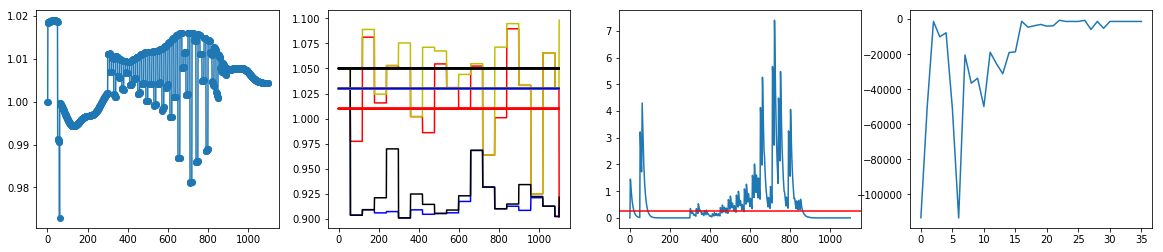

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.06183362007141113 seconds ---
--- 0.06981110572814941 seconds ---
--- 0.07878851890563965 seconds ---
--- 0.07379984855651855 seconds ---
--- 0.06482338905334473 seconds ---
--- 0.07080912590026855 seconds ---
--- 0.06981325149536133 seconds ---
--- 0.07978582382202148 seconds ---
--- 0.06582212448120117 seconds ---
--- 0.07878971099853516 seconds ---
--- 0.07081007957458496 seconds ---
--- 0.06582307815551758 seconds ---
--- 0.06881451606750488 seconds ---
--- 0.07479572296142578 seconds ---
--- 0.07679462432861328 seconds ---
--- 0.0688164234161377 seconds ---
--- 0.07080936431884766 seconds ---
--- 0.06881427764892578 seconds ---
--- 0.05884146690368652 seconds ---
-628.1411654619775
--- 61.529401540756226 seconds ---


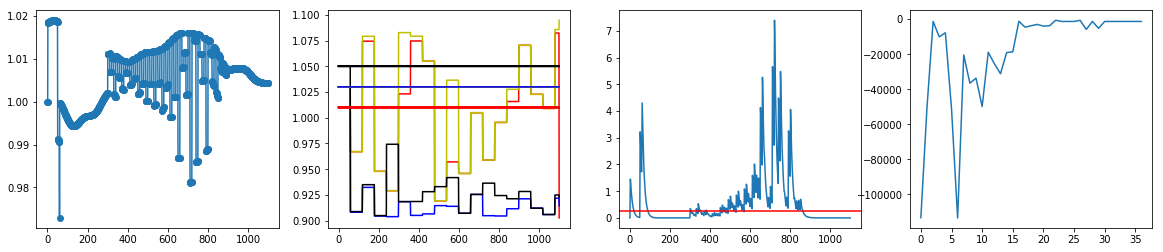

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.06781816482543945 seconds ---
--- 0.06881260871887207 seconds ---
--- 0.06981086730957031 seconds ---
--- 0.07081103324890137 seconds ---
--- 0.07878971099853516 seconds ---
--- 0.06781482696533203 seconds ---
--- 0.060837507247924805 seconds ---
--- 0.07280468940734863 seconds ---
--- 0.06382894515991211 seconds ---
--- 0.0638265609741211 seconds ---
--- 0.05584907531738281 seconds ---
--- 0.06482625007629395 seconds ---
--- 0.07380247116088867 seconds ---
--- 0.06183505058288574 seconds ---
--- 0.06283140182495117 seconds ---
--- 0.0718071460723877 seconds ---
--- 0.07280349731445312 seconds ---
--- 0.0638272762298584 seconds ---
--- 0.06482362747192383 seconds ---
-628.1411654619775
--- 60.66571259498596 seconds ---


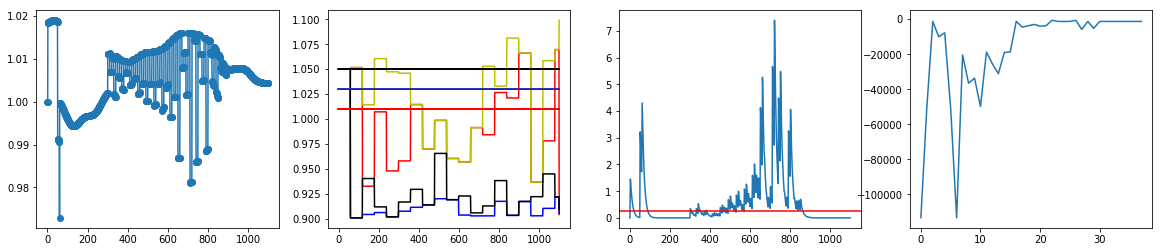

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.0827791690826416 seconds ---
--- 0.07878923416137695 seconds ---
--- 0.08078312873840332 seconds ---
--- 0.08178019523620605 seconds ---
--- 0.0718069076538086 seconds ---
--- 0.0747988224029541 seconds ---
--- 0.06681990623474121 seconds ---
--- 0.07080912590026855 seconds ---
--- 0.08477139472961426 seconds ---
--- 0.06283092498779297 seconds ---
--- 0.06283092498779297 seconds ---
--- 0.06283020973205566 seconds ---
--- 0.06781935691833496 seconds ---
--- 0.06482458114624023 seconds ---
--- 0.07180523872375488 seconds ---
--- 0.06482386589050293 seconds ---
--- 0.06283020973205566 seconds ---
--- 0.06781744956970215 seconds ---
--- 0.06382870674133301 seconds ---
-628.1411654619775
--- 62.24349403381348 seconds ---


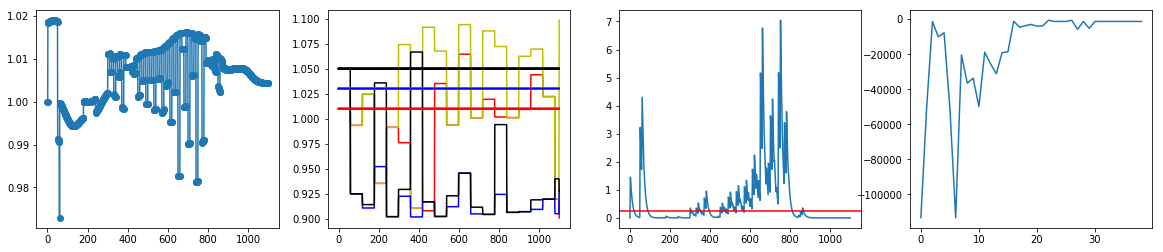

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.074798583984375 seconds ---
--- 0.07779049873352051 seconds ---
--- 0.07080650329589844 seconds ---
--- 0.07878923416137695 seconds ---
--- 0.07380127906799316 seconds ---
--- 0.06582379341125488 seconds ---
--- 0.08177876472473145 seconds ---
--- 0.07081007957458496 seconds ---
--- 0.06781530380249023 seconds ---
--- 0.07380175590515137 seconds ---
--- 0.07379865646362305 seconds ---
--- 0.07779073715209961 seconds ---
--- 0.07978558540344238 seconds ---
--- 0.0747981071472168 seconds ---
--- 0.071807861328125 seconds ---
--- 0.07579612731933594 seconds ---
--- 0.06183457374572754 seconds ---
--- 0.07180666923522949 seconds ---
--- 0.06482577323913574 seconds ---
-628.1411654619775
--- 58.257158041000366 seconds ---


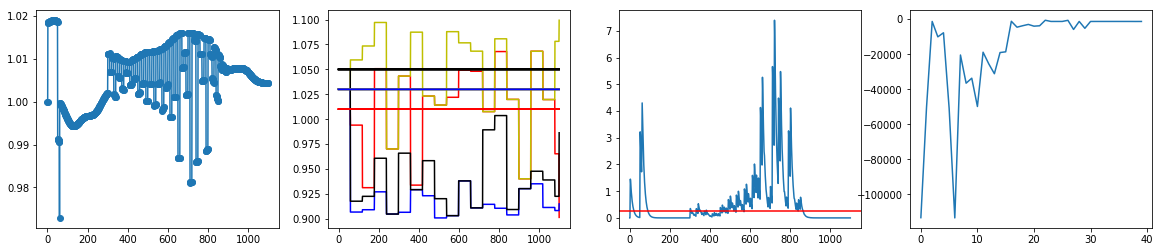

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.07878923416137695 seconds ---
--- 0.11070370674133301 seconds ---
--- 0.0688161849975586 seconds ---
--- 0.06681990623474121 seconds ---
--- 0.0638275146484375 seconds ---
--- 0.06881523132324219 seconds ---
--- 0.07579636573791504 seconds ---
--- 0.0638270378112793 seconds ---
--- 0.07180476188659668 seconds ---
--- 0.06682038307189941 seconds ---
--- 0.06182861328125 seconds ---
--- 0.08078455924987793 seconds ---
--- 0.06482434272766113 seconds ---
--- 0.07978582382202148 seconds ---
--- 0.07779145240783691 seconds ---
--- 0.06183290481567383 seconds ---
--- 0.06582283973693848 seconds ---
--- 0.0718085765838623 seconds ---
--- 0.07978558540344238 seconds ---
-628.1411654619775
--- 61.46557807922363 seconds ---


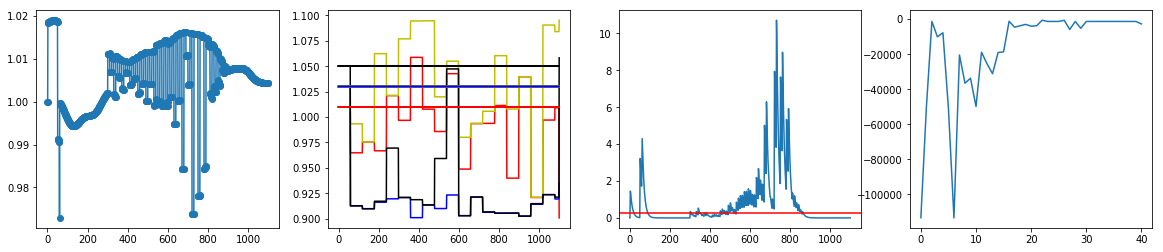

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.0718071460723877 seconds ---
--- 0.07379913330078125 seconds ---
--- 0.06781935691833496 seconds ---
--- 0.06183290481567383 seconds ---
--- 0.06582307815551758 seconds ---
--- 0.05884218215942383 seconds ---
--- 0.08078360557556152 seconds ---
--- 0.06582236289978027 seconds ---
--- 0.07180523872375488 seconds ---
--- 0.07081031799316406 seconds ---
--- 0.07080793380737305 seconds ---
--- 0.07679414749145508 seconds ---
--- 0.07380080223083496 seconds ---
--- 0.06981420516967773 seconds ---
--- 0.06382989883422852 seconds ---
--- 0.06981325149536133 seconds ---
--- 0.06682133674621582 seconds ---
--- 0.059836387634277344 seconds ---
--- 0.060834407806396484 seconds ---
-628.1411654619775
--- 56.115886926651 seconds ---


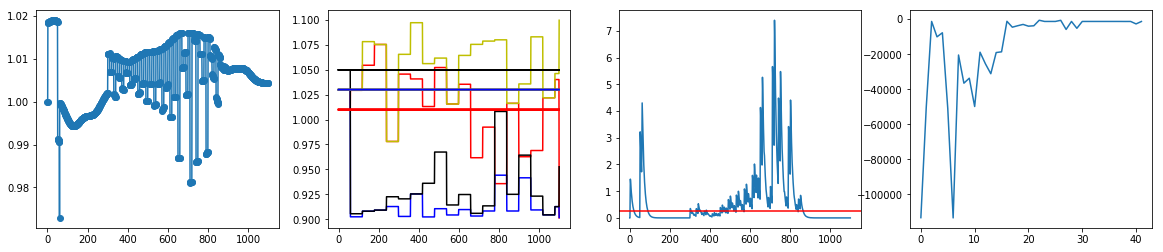

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.06981325149536133 seconds ---
--- 0.07679104804992676 seconds ---
--- 0.0638284683227539 seconds ---
--- 0.07579708099365234 seconds ---
--- 0.07679033279418945 seconds ---
--- 0.10571670532226562 seconds ---
--- 0.07878684997558594 seconds ---
--- 0.09873414039611816 seconds ---
--- 0.06881546974182129 seconds ---
--- 0.05784344673156738 seconds ---
--- 0.06283116340637207 seconds ---
--- 0.06482577323913574 seconds ---
--- 0.06981277465820312 seconds ---
--- 0.06682014465332031 seconds ---
--- 0.06183338165283203 seconds ---
--- 0.05884289741516113 seconds ---
--- 0.05784440040588379 seconds ---
--- 0.0747976303100586 seconds ---
--- 0.06482434272766113 seconds ---
-628.1411654619775
--- 61.81962847709656 seconds ---


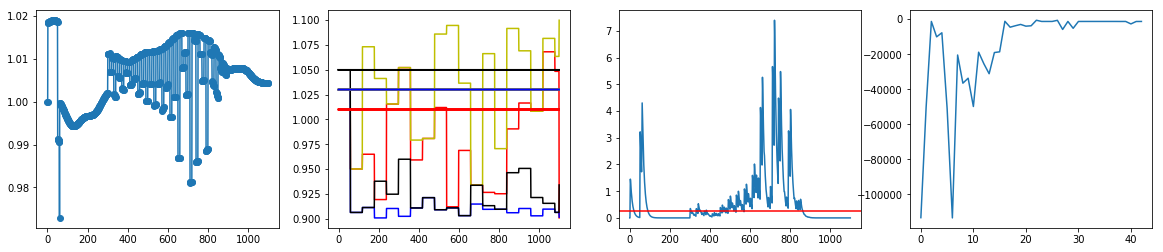

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.071807861328125 seconds ---
--- 0.0638267993927002 seconds ---
--- 0.05585026741027832 seconds ---
--- 0.06582450866699219 seconds ---
--- 0.07280564308166504 seconds ---
--- 0.07579731941223145 seconds ---
--- 0.0747992992401123 seconds ---
--- 0.06682300567626953 seconds ---
--- 0.060837507247924805 seconds ---
--- 0.07579684257507324 seconds ---
--- 0.07679319381713867 seconds ---
--- 0.06981158256530762 seconds ---
--- 0.07081079483032227 seconds ---
--- 0.06382918357849121 seconds ---
--- 0.06482648849487305 seconds ---
--- 0.07779192924499512 seconds ---
--- 0.07579588890075684 seconds ---
--- 0.0608363151550293 seconds ---
--- 0.0638267993927002 seconds ---
-628.1411654619775
--- 70.52733278274536 seconds ---


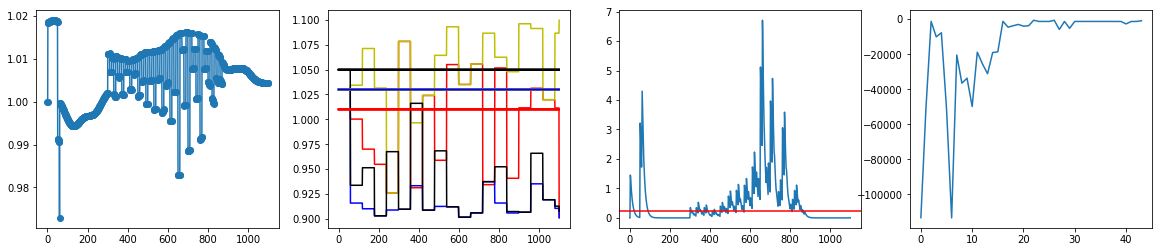

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.0747976303100586 seconds ---
--- 0.07180595397949219 seconds ---
--- 0.06781911849975586 seconds ---
--- 0.06681966781616211 seconds ---
--- 0.0718073844909668 seconds ---
--- 0.07810711860656738 seconds ---
--- 0.06248164176940918 seconds ---
--- 0.062485456466674805 seconds ---
--- 0.07080912590026855 seconds ---
--- 0.07280397415161133 seconds ---
--- 0.07080721855163574 seconds ---
--- 0.06248641014099121 seconds ---
--- 0.07810759544372559 seconds ---
--- 0.06482648849487305 seconds ---
--- 0.07811331748962402 seconds ---
--- 0.07080984115600586 seconds ---
--- 0.07081007957458496 seconds ---
--- 0.06248617172241211 seconds ---
--- 0.07810378074645996 seconds ---
-628.1411654619775
--- 61.60526895523071 seconds ---


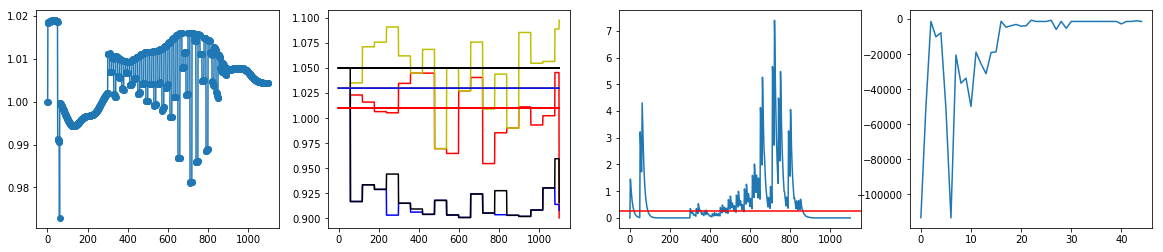

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.062482595443725586 seconds ---
--- 0.07579827308654785 seconds ---
--- 0.04686141014099121 seconds ---
--- 0.0747988224029541 seconds ---
--- 0.09372687339782715 seconds ---
--- 0.06248211860656738 seconds ---
--- 0.062482595443725586 seconds ---
--- 0.07810831069946289 seconds ---
--- 0.07810473442077637 seconds ---
--- 0.07810258865356445 seconds ---
--- 0.0777897834777832 seconds ---
--- 0.046864986419677734 seconds ---
--- 0.0747995376586914 seconds ---
--- 0.062483787536621094 seconds ---
--- 0.07480001449584961 seconds ---
--- 0.062485456466674805 seconds ---
--- 0.0781102180480957 seconds ---
--- 0.07180643081665039 seconds ---
--- 0.08676767349243164 seconds ---
-628.1411654619775
--- 57.87404465675354 seconds ---


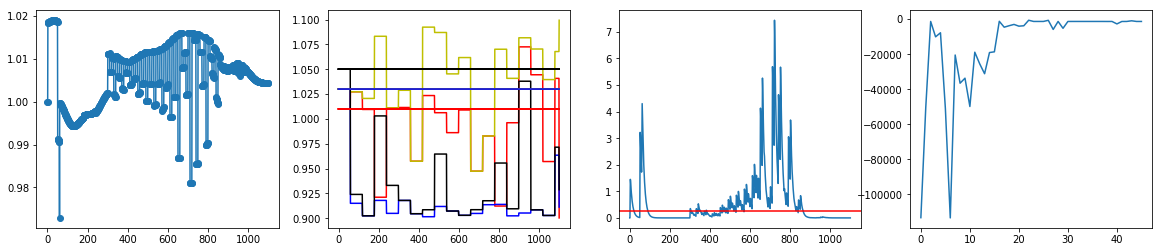

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.07810759544372559 seconds ---
--- 0.07810306549072266 seconds ---
--- 0.06248664855957031 seconds ---
--- 0.06247997283935547 seconds ---
--- 0.05784487724304199 seconds ---
--- 0.06981277465820312 seconds ---
--- 0.04686236381530762 seconds ---
--- 0.07810568809509277 seconds ---
--- 0.07080912590026855 seconds ---
--- 0.07810664176940918 seconds ---
--- 0.06881570816040039 seconds ---
--- 0.07810783386230469 seconds ---
--- 0.061832427978515625 seconds ---
--- 0.06248736381530762 seconds ---
--- 0.06248760223388672 seconds ---
--- 0.07810640335083008 seconds ---
--- 0.07810306549072266 seconds ---
--- 0.07810854911804199 seconds ---
--- 0.06569051742553711 seconds ---
-628.1411654619775
--- 55.427363872528076 seconds ---


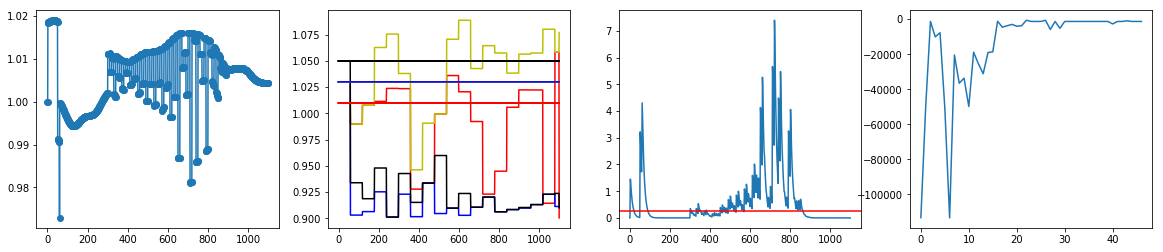

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.07380294799804688 seconds ---
--- 0.07380032539367676 seconds ---
--- 0.07679224014282227 seconds ---
--- 0.06248760223388672 seconds ---
--- 0.06582188606262207 seconds ---
--- 0.07810664176940918 seconds ---
--- 0.07810759544372559 seconds ---
--- 0.06248283386230469 seconds ---
--- 0.07810163497924805 seconds ---
--- 0.0718069076538086 seconds ---
--- 0.07480001449584961 seconds ---
--- 0.07810854911804199 seconds ---
--- 0.062487125396728516 seconds ---
--- 0.07810378074645996 seconds ---
--- 0.06248593330383301 seconds ---
--- 0.0844423770904541 seconds ---
--- 0.07062268257141113 seconds ---
--- 0.07810521125793457 seconds ---
--- 0.06248593330383301 seconds ---
-628.1411654619775
--- 56.00876235961914 seconds ---


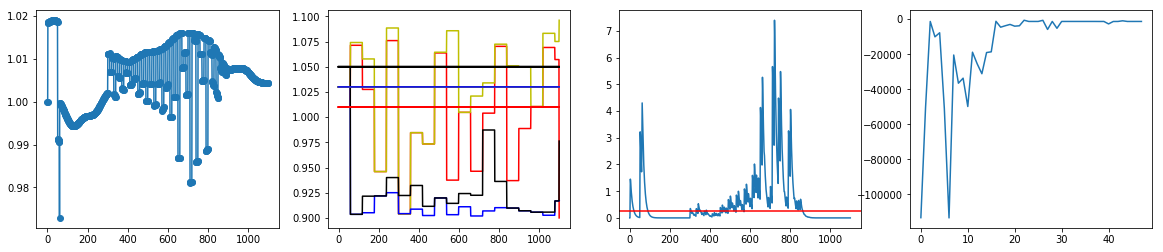

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.07280421257019043 seconds ---
--- 0.062484025955200195 seconds ---
--- 0.06781935691833496 seconds ---
--- 0.07810544967651367 seconds ---
--- 0.0658254623413086 seconds ---
--- 0.06248664855957031 seconds ---
--- 0.07810854911804199 seconds ---
--- 0.07810711860656738 seconds ---
--- 0.07810854911804199 seconds ---
--- 0.10934996604919434 seconds ---
--- 0.07978487014770508 seconds ---
--- 0.0781090259552002 seconds ---
--- 0.059839487075805664 seconds ---
--- 0.06248736381530762 seconds ---
--- 0.07380080223083496 seconds ---
--- 0.06248664855957031 seconds ---
--- 0.0668182373046875 seconds ---
--- 0.06969571113586426 seconds ---
--- 0.06682205200195312 seconds ---
-628.1411654619775
--- 56.31457543373108 seconds ---


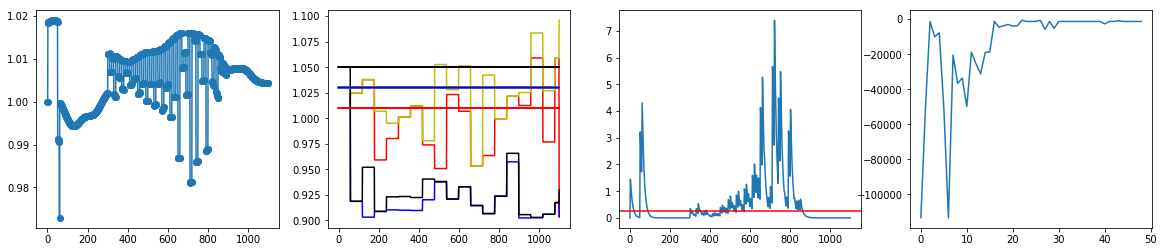

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.06248140335083008 seconds ---
--- 0.07810497283935547 seconds ---
--- 0.06248307228088379 seconds ---
--- 0.0797877311706543 seconds ---
--- 0.062486886978149414 seconds ---
--- 0.0638277530670166 seconds ---
--- 0.06248164176940918 seconds ---
--- 0.0781087875366211 seconds ---
--- 0.07070803642272949 seconds ---
--- 0.0624852180480957 seconds ---
--- 0.07810807228088379 seconds ---
--- 0.0624849796295166 seconds ---
--- 0.0747978687286377 seconds ---
--- 0.06283164024353027 seconds ---
--- 0.06248641014099121 seconds ---
--- 0.06248664855957031 seconds ---
--- 0.07080960273742676 seconds ---
--- 0.06781911849975586 seconds ---
--- 0.07081103324890137 seconds ---
-628.1411654619775
--- 58.89669346809387 seconds ---


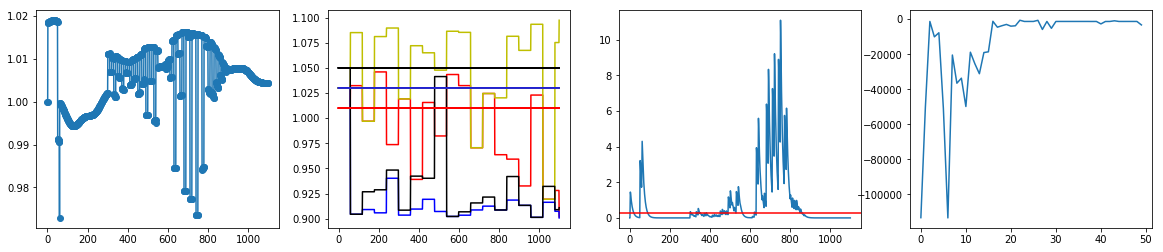

In [8]:
totalPoints = [[],[],[],[],[],[],[],[],[],[],[],[],[]]
############################################
########### INIT FOR AGENT #################
############################################

#init action
oldAction = []
action = []

#init state
oldState = []
state = []

#init reward
reward = None

mb_state=[]
mb_action=[]
mb_reward=[]
mb_nextstate=[]
buffer = ReplayBuffer(300)
BATCH_SIZE = 30

for ep in range(50):
    Load = Origin_Load.copy()
    Generation = Origin_Generation.copy()
    #this is for permutate the Load and Generation profile on each node
    #Load = np.random.permutation(Load.T).T
    #Generation = np.random.permutation(Generation.T).T

    #this is to permutate the Load and Generation profile
    #temp = np.copy(Load[:, 0:Number_of_Inverters])
    #Load[:, 0:Number_of_Inverters] = Load[:, Number_of_Inverters:Number_of_Inverters*2]
    #Load[:, Number_of_Inverters:Number_of_Inverters*2] = temp
    #temp = np.copy(Generation[:, 0:Number_of_Inverters])
    #Generation[:, 0:Number_of_Inverters] = Generation[:, Number_of_Inverters:Number_of_Inverters*2]
    #Generation[:, Number_of_Inverters:Number_of_Inverters*2] = temp

    #Create noise vector
    Noise = np.empty([TotalTimeSteps, TotalLoads])
    for node in range(TotalLoads):
        Noise[:,node] = np.random.randn(TotalTimeSteps) 

    #Add noise to loads
    for node in range(TotalLoads):
        Load[:,node] = Load[:,node] + NoiseMultiplyer*Noise[:,node]

    if NoiseMultiplyer > 0:
        print('Load Interpolation has been done. Noise was added to the load profile.') 
    else:
        print('Load Interpolation has been done. No Noise was added to the load profile.') 

    MaxGenerationPossible = np.max(Generation, axis = 0)
    sbar = MaxGenerationPossible
    
    start_time = time.time()
    #########################################################
    ################### RESTART OPENDSS #####################
    #########################################################
    DSSStart = DSSStartup()
    DSSText =DSSStart['dsstext']
    DSSSolution = DSSStart['dsssolution']
    DSSCircuit = DSSStart['dsscircuit']
    DSSObj = DSSStart['dssobj']
    DSSMon = DSSCircuit.Monitors
    DSSText.command = 'Compile C:\\feeders\\feeder34_B_NR\\feeder34_B_NR.dss'
    DSSSolution.Solve()
    if not DSSSolution.Converged:
        print('Initial Solution Not Converged. Check Model for Convergence')
    else:
        print('Initial Model Converged. Proceeding to Next Step.')
        #Doing this solve command is required for GridPV, that is why the monitors
        #go under a reset process
        DSSMon.ResetAll
        setSolutionParams(DSSObj,'daily',1,1,'off',1000000,30000)
        #Easy process to get all names and count of loads, a trick to avoid
        #some more lines of code
        TotalLoads=DSSCircuit.Loads.Count
        AllLoadNames=DSSCircuit.Loads.AllNames
        print('OpenDSS Model Compliation Done.')

    ############################################
    ############ INIT NODES ####################
    ############################################
    nodes = {}
    features = ['Voltage', 'Generation', 'P', 'Q']

    for i in range(len(AllLoadNames)):
        df = pd.DataFrame(columns=list(range(TotalTimeSteps)),index=features)
        nodes[i] = df
        nodes[i].loc['Generation'] = Generation[:,i]
        nodes[i].loc['P'] = 0
        nodes[i].loc['Q'] = 0

    ################################################
    ############ INIT INVERTERS ####################
    ################################################
    inverters = {}
    features = ['VBP', 'FilterVoltage', 'Generation', 'sbar', 'P_inv', 'Q_inv' ,'counter', 'ime_output', 'ep_output', 'yk', 'upk','uqk']

    offset = 5
    numberofInverters = Number_of_Inverters

    for i in range(len(AllLoadNames)):
        inverters[i] = []
        if offset-1 < i < numberofInverters + offset:
            df = pd.DataFrame(columns=list(range(TotalTimeSteps)),index=features)
            df.at['FilterVoltage', 0] = 0
            df.loc['Generation'] = Generation[:,i]
            df.loc['sbar'] = sbar[i]
            df.loc['counter'] = 0
            df.loc['ime_output'] = 0
            df.loc['ep_output'] = 0
            df.loc['yk'] = 0
            df.loc['P_inv'] = 0
            df.loc['Q_inv'] = 0
            df.loc['upk'] = 0
            df.loc['uqk'] = 0
            inverters[i].append(df)

    ############################################
    ########### INIT VBPCURVE ##################
    ############################################
    for i in range(len(AllLoadNames)):
        for j in range(len(inverters[i])):
            for k in range(TotalTimeSteps):
                inverters[i][j].at['VBP',k] = np.array([1.01, 1.03, 1.03, 1.05])

    VBPcounter = [0,0,0,0,0,0,0,0,0,0,0,0,0]

    controlInv = list(range(7,8))    
    points = [0,0,0,0,0,0,0,0,0,0,0,0,0]
    terminal = False
    
    for timeStep in range(TotalTimeSteps):
        VBPcounter = [x+1 for x in VBPcounter] 
        ####################################################
        ################ run the simulation ################
        ####################################################
        #for the first steps, we just init voltage value, no pq injection
        if timeStep == 0:
            for node in range(len(AllLoadNames)):
                nodeName = AllLoadNames[node]
                setLoadInfo(DSSObj, [nodeName], 'kw', [Load[timeStep, node]])
                setLoadInfo(DSSObj, [nodeName], 'kvar', [pf_converted*Load[timeStep, node]])
        else:
            for node in range(len(AllLoadNames)):
                nodeName = AllLoadNames[node]
                setLoadInfo(DSSObj, [nodeName], 'kw', [Load[timeStep, node] + nodes[node].at['P', timeStep-1]])
                setLoadInfo(DSSObj, [nodeName], 'kvar', [pf_converted*Load[timeStep, node] + nodes[node].at['Q', timeStep-1]])

        DSSSolution.Solve()
        if (not DSSSolution.Converged):
            print('Solution Not Converged at Step:', timeStep)

        #get the voltage info
        nodeInfo = getLoadInfo(DSSObj, [])
        #distribute voltage to node
        for i in range(len(nodes)):
            node = nodes[i]
            node.at['Voltage', timeStep] = nodeInfo[i]['voltagePU']
            if timeStep == 0 or timeStep == 1:
                node.at['Voltage', timeStep] = 1
        #############################################################
        #############################################################
        #############################################################
        if timeStep == TimeStepOfHack:
            for node in range(len(AllLoadNames)):
                if inverters[node] != []:
                    inverter = inverters[node][0]
                    #create new inverter
                    hackedInv = copy.deepcopy(inverter)
                    for k in range(timeStep, TotalTimeSteps):
                        hackedInv.at['VBP',k] = np.array([1.01, 1.015, 1.015, 1.02])

                    hackedInv.loc['sbar'][timeStep:] = hackedInv.loc['sbar'][timeStep:]*PercentHacked[node]
                    hackedInv.loc['Generation'][timeStep:] = hackedInv.loc['Generation'][timeStep:]*PercentHacked[node]
                    inverters[node].append(hackedInv)
                    #generation and sbar change on the original inverter
                    inverter.loc['sbar'][timeStep:] = inverter.loc['sbar'][timeStep:]*(1-PercentHacked[node])
                    inverter.loc['Generation'][timeStep:] = inverter.loc['Generation'][timeStep:]*(1-PercentHacked[node])
        ########################################################################
        ########################################################################
        ########################################################################
        
        if timeStep == TotalTimeSteps-1:
            terminal = True
            
        if timeStep != 0:
            for node in range(len(AllLoadNames)):
                #if we have inverters at that node then...
                if inverters[node] != []:
                    invertersNode = inverters[node] #get the list of inverters at that node
                    for inverter in invertersNode: #get an inverter at that node
                        #increase the counter
                        inverter.at['counter',timeStep] = inverter.at['counter',timeStep-1] + 1
                        if inverter.at['counter',timeStep-1] == Delay_VoltageSampling[node]:
                            inverter.at['counter',timeStep] = 1
                            
                        #get State
                        if (node in controlInv) and (inverter is invertersNode[0]):
                            if VBPcounter[node-offset] == Delay_VBPCurveShift[node] or terminal == True:
                                if terminal == False:
                                    length = Delay_VBPCurveShift[node]
                                    V = nodes[node].loc['Voltage',timeStep-length+1:timeStep]
                                    G = inverter.loc['Generation', timeStep-length+1:timeStep] 
                                    L = Load[timeStep-length+1:timeStep+1, node]
                                else:
                                    length = VBPcounter[node-offset]
                                    V = nodes[node].loc['Voltage',timeStep-length+1:]
                                    G = inverter.loc['Generation', timeStep-length+1:]
                                    L = Load[timeStep-length+1:, node]
                                    
                                oldState = state
                                state = processing_state(V,G,L)
                                #reset VBPcounter
                                VBPcounter[node-offset] = 0
                                #store action                        
                                oldAction = copy.deepcopy(action)
                                
                                #get Action from Agent
                                action = agent.action_respond(state.reshape((1,60,3)))
                                #apply strict boundary
                                if action[1] < action[0]:
                                    action[0] = action[1]
                                if action[3] < action[2]:
                                    action[2] = action[3]
                                for k in range(timeStep, TotalTimeSteps):
                                    inverter.at['VBP',k] = copy.deepcopy(action*0.1 + 1)
                                
                                #reward
                                #caculate yk for that inverter
                                inverter.at['yk', timeStep], inverter.at['ime_output', timeStep], inverter.at['ep_output', timeStep] = voltage_observer(
                                         nodes[node].at['Voltage', timeStep], 
                                         nodes[node].at['Voltage', timeStep-1],
                                         inverter.at['ime_output', timeStep-1], 
                                         inverter.at['ep_output', timeStep-1], 
                                         inverter.at['yk', timeStep-1])

                                numberYks = inverter.loc['yk', timeStep-length+1:timeStep]
                                numberYks = numberYks - 0.25
                                numberYks = numberYks[numberYks > 0]
                                reward = - sum(numberYks**2)
                                
                                #sum of reward for that ep
                                points[node-offset] += reward
                                
                                
                                if oldAction != [] and oldState != []:
                                    if terminal: 
                                        ter = 1
                                    else:
                                        ter = 0
                                    buffer.add(oldState.reshape((60,3)), oldAction, np.array([reward]), np.array([ter]), state.reshape((60,3)))
                                
                                if buffer.size() > BATCH_SIZE:
                                    batch = {}
                                    mb_state, mb_action, mb_reward, mb_ter, mb_nextstate = buffer.sample_batch(BATCH_SIZE)
                                    batch['observations'] = mb_state
                                    batch['actions'] = mb_action
                                    batch['rewards'] = mb_reward
                                    batch['next_observations'] = mb_nextstate
                                    batch['rewards'] = mb_reward
                                    batch['terminals'] = mb_ter
                                    start_time_train = time.time()
                                    agent.do_training(batch)
                                    print("--- %s seconds ---" % (time.time() - start_time_train))
                        #################################################                        
                        #################################################
                        #execute action
                        inverter.at['Q_inv', timeStep], inverter.at['P_inv', timeStep], inverter.at['FilterVoltage', timeStep] = inverter_qp_injection(
                            inverter.at['counter',timeStep],
                            nodes[node].at['Voltage', timeStep],
                            nodes[node].at['Voltage', timeStep-1],
                            inverter.at['FilterVoltage', timeStep-1],
                            inverter.at['Generation', timeStep],
                            inverter.at['VBP', timeStep],
                            inverter.at['sbar', timeStep],
                            Delay_VoltageSampling[node])
                        
                        inverter.at['yk', timeStep], inverter.at['ime_output', timeStep], inverter.at['ep_output', timeStep] = voltage_observer(
                                         nodes[node].at['Voltage', timeStep], 
                                         nodes[node].at['Voltage', timeStep-1],
                                         inverter.at['ime_output', timeStep-1], 
                                         inverter.at['ep_output', timeStep-1], 
                                         inverter.at['yk', timeStep-1])

                        
                        
                        #caculate P Q injection at the node
                        nodes[node].at['P', timeStep] += inverter.at['P_inv', timeStep]
                        nodes[node].at['Q', timeStep] += inverter.at['Q_inv', timeStep]

    ######### drawing #####################
    
    for i in range(len(points)):
        totalPoints[i].append(points[i])
    print(max(totalPoints[7-offset]))
    print("--- %s seconds ---" % (time.time() - start_time))
    f = plt.figure()
    f.set_figheight(4)
    f.set_figwidth(20)
    f.add_subplot(1,4,1)
    plt.plot(nodes[7].loc['Voltage'], marker='o')
    
    for i in range(5,18):
        x = inverters[i][0].loc['VBP']
        y=np.zeros([len(x),x[0].shape[0]])
        for i in range(len(x)):
            y[i,:] = x[i]
        f.add_subplot(1,4,2)
        plt.plot(y[:,0], 'r')
        plt.plot(y[:,1], 'y')
        plt.plot(y[:,2], 'b')
        plt.plot(y[:,3], 'k')
    
    f.add_subplot(1,4,3)
    for i in range(7,8):
        yk = inverters[i][0].loc['yk']
        plt.plot(yk)
    plt.axhline(y=0.25, color='r', linestyle='-')
    f.add_subplot(1,4,4)
    plt.plot(totalPoints[7-offset])
    plt.show(block=True)
    f.savefig(str(ep) + '.png')


Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
-34.29693493587141
--- 60.151687145233154 seconds ---


D:\Apps\Anacoda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


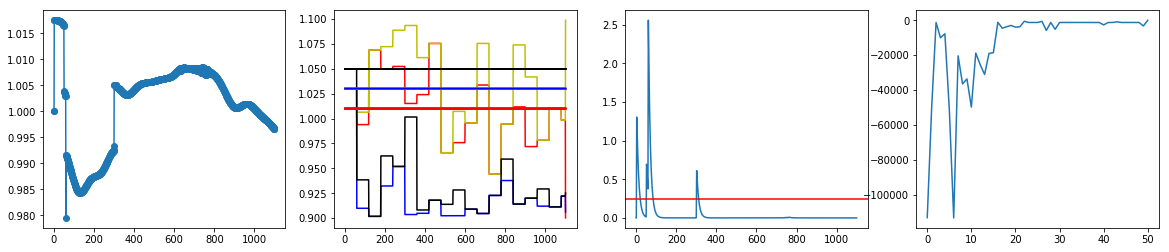

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
-18.81179130721874
--- 58.2304151058197 seconds ---


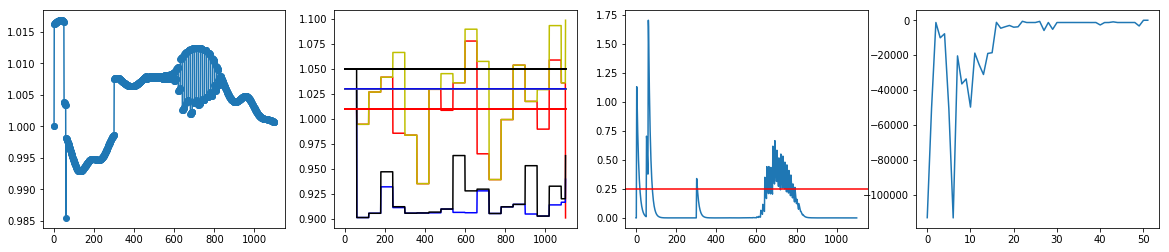

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
-17.148795246283612
--- 54.2080500125885 seconds ---


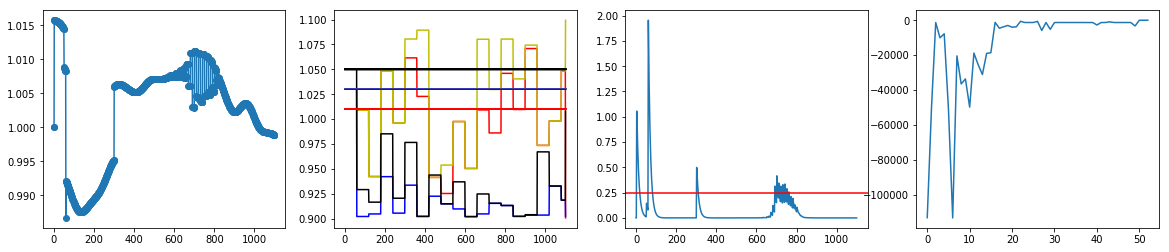

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
-6.377878249184119
--- 57.40389347076416 seconds ---


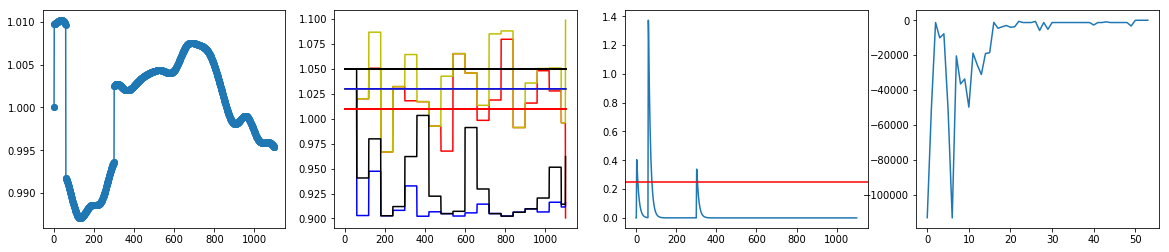

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
-6.377878249184119
--- 55.82790756225586 seconds ---


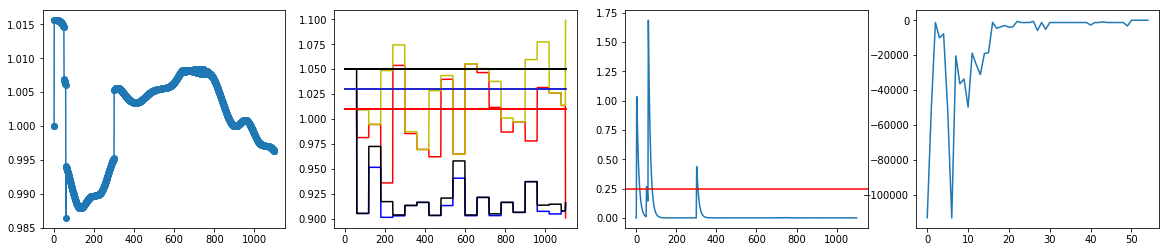

In [9]:
for ep in range(5):
    Load = Origin_Load.copy()
    Generation = Origin_Generation.copy()
    #this is for permutate the Load and Generation profile on each node
    Load = np.random.permutation(Load.T).T
    Generation = np.random.permutation(Generation.T).T

    #this is to permutate the Load and Generation profile
    #temp = np.copy(Load[:, 0:Number_of_Inverters])
    #Load[:, 0:Number_of_Inverters] = Load[:, Number_of_Inverters:Number_of_Inverters*2]
    #Load[:, Number_of_Inverters:Number_of_Inverters*2] = temp
    #temp = np.copy(Generation[:, 0:Number_of_Inverters])
    #Generation[:, 0:Number_of_Inverters] = Generation[:, Number_of_Inverters:Number_of_Inverters*2]
    #Generation[:, Number_of_Inverters:Number_of_Inverters*2] = temp

    #Create noise vector
    Noise = np.empty([TotalTimeSteps, TotalLoads])
    for node in range(TotalLoads):
        Noise[:,node] = np.random.randn(TotalTimeSteps) 

    #Add noise to loads
    for node in range(TotalLoads):
        Load[:,node] = Load[:,node] + NoiseMultiplyer*Noise[:,node]

    if NoiseMultiplyer > 0:
        print('Load Interpolation has been done. Noise was added to the load profile.') 
    else:
        print('Load Interpolation has been done. No Noise was added to the load profile.') 

    MaxGenerationPossible = np.max(Generation, axis = 0)
    sbar = MaxGenerationPossible
    
    start_time = time.time()
    #########################################################
    ################### RESTART OPENDSS #####################
    #########################################################
    DSSStart = DSSStartup()
    DSSText =DSSStart['dsstext']
    DSSSolution = DSSStart['dsssolution']
    DSSCircuit = DSSStart['dsscircuit']
    DSSObj = DSSStart['dssobj']
    DSSMon = DSSCircuit.Monitors
    DSSText.command = 'Compile C:\\feeders\\feeder34_B_NR\\feeder34_B_NR.dss'
    DSSSolution.Solve()
    if not DSSSolution.Converged:
        print('Initial Solution Not Converged. Check Model for Convergence')
    else:
        print('Initial Model Converged. Proceeding to Next Step.')
        #Doing this solve command is required for GridPV, that is why the monitors
        #go under a reset process
        DSSMon.ResetAll
        setSolutionParams(DSSObj,'daily',1,1,'off',1000000,30000)
        #Easy process to get all names and count of loads, a trick to avoid
        #some more lines of code
        TotalLoads=DSSCircuit.Loads.Count
        AllLoadNames=DSSCircuit.Loads.AllNames
        print('OpenDSS Model Compliation Done.')

    ############################################
    ############ INIT NODES ####################
    ############################################
    nodes = {}
    features = ['Voltage', 'Generation', 'P', 'Q']

    for i in range(len(AllLoadNames)):
        df = pd.DataFrame(columns=list(range(TotalTimeSteps)),index=features)
        nodes[i] = df
        nodes[i].loc['Generation'] = Generation[:,i]
        nodes[i].loc['P'] = 0
        nodes[i].loc['Q'] = 0

    ################################################
    ############ INIT INVERTERS ####################
    ################################################
    inverters = {}
    features = ['VBP', 'FilterVoltage', 'Generation', 'sbar', 'P_inv', 'Q_inv' ,'counter', 'ime_output', 'ep_output', 'yk', 'upk','uqk']

    offset = 5
    numberofInverters = Number_of_Inverters

    for i in range(len(AllLoadNames)):
        inverters[i] = []
        if offset-1 < i < numberofInverters + offset:
            df = pd.DataFrame(columns=list(range(TotalTimeSteps)),index=features)
            df.at['FilterVoltage', 0] = 0
            df.loc['Generation'] = Generation[:,i]
            df.loc['sbar'] = sbar[i]
            df.loc['counter'] = 0
            df.loc['ime_output'] = 0
            df.loc['ep_output'] = 0
            df.loc['yk'] = 0
            df.loc['P_inv'] = 0
            df.loc['Q_inv'] = 0
            df.loc['upk'] = 0
            df.loc['uqk'] = 0
            inverters[i].append(df)

    ############################################
    ########### INIT VBPCURVE ##################
    ############################################
    for i in range(len(AllLoadNames)):
        for j in range(len(inverters[i])):
            for k in range(TotalTimeSteps):
                inverters[i][j].at['VBP',k] = np.array([1.01, 1.03, 1.03, 1.05])

    VBPcounter = [0,0,0,0,0,0,0,0,0,0,0,0,0]

    controlInv = list(range(7,8))    
    points = [0,0,0,0,0,0,0,0,0,0,0,0,0]
    terminal = False
    
    for timeStep in range(TotalTimeSteps):
        VBPcounter = [x+1 for x in VBPcounter] 
        ####################################################
        ################ run the simulation ################
        ####################################################
        #for the first steps, we just init voltage value, no pq injection
        if timeStep == 0:
            for node in range(len(AllLoadNames)):
                nodeName = AllLoadNames[node]
                setLoadInfo(DSSObj, [nodeName], 'kw', [Load[timeStep, node]])
                setLoadInfo(DSSObj, [nodeName], 'kvar', [pf_converted*Load[timeStep, node]])
        else:
            for node in range(len(AllLoadNames)):
                nodeName = AllLoadNames[node]
                setLoadInfo(DSSObj, [nodeName], 'kw', [Load[timeStep, node] + nodes[node].at['P', timeStep-1]])
                setLoadInfo(DSSObj, [nodeName], 'kvar', [pf_converted*Load[timeStep, node] + nodes[node].at['Q', timeStep-1]])

        DSSSolution.Solve()
        if (not DSSSolution.Converged):
            print('Solution Not Converged at Step:', timeStep)

        #get the voltage info
        nodeInfo = getLoadInfo(DSSObj, [])
        #distribute voltage to node
        for i in range(len(nodes)):
            node = nodes[i]
            node.at['Voltage', timeStep] = nodeInfo[i]['voltagePU']
            if timeStep == 0 or timeStep == 1:
                node.at['Voltage', timeStep] = 1
        #############################################################
        #############################################################
        #############################################################
        if timeStep == TimeStepOfHack:
            for node in range(len(AllLoadNames)):
                if inverters[node] != []:
                    inverter = inverters[node][0]
                    #create new inverter
                    hackedInv = copy.deepcopy(inverter)
                    for k in range(timeStep, TotalTimeSteps):
                        hackedInv.at['VBP',k] = np.array([1.01, 1.015, 1.015, 1.02])

                    hackedInv.loc['sbar'][timeStep:] = hackedInv.loc['sbar'][timeStep:]*PercentHacked[node]
                    hackedInv.loc['Generation'][timeStep:] = hackedInv.loc['Generation'][timeStep:]*PercentHacked[node]
                    inverters[node].append(hackedInv)
                    #generation and sbar change on the original inverter
                    inverter.loc['sbar'][timeStep:] = inverter.loc['sbar'][timeStep:]*(1-PercentHacked[node])
                    inverter.loc['Generation'][timeStep:] = inverter.loc['Generation'][timeStep:]*(1-PercentHacked[node])
        ########################################################################
        ########################################################################
        ########################################################################
        
        if timeStep == TotalTimeSteps-1:
            terminal = True
            
        if timeStep != 0:
            for node in range(len(AllLoadNames)):
                #if we have inverters at that node then...
                if inverters[node] != []:
                    invertersNode = inverters[node] #get the list of inverters at that node
                    for inverter in invertersNode: #get an inverter at that node
                        #increase the counter
                        inverter.at['counter',timeStep] = inverter.at['counter',timeStep-1] + 1
                        if inverter.at['counter',timeStep-1] == Delay_VoltageSampling[node]:
                            inverter.at['counter',timeStep] = 1
                            
                        #get State
                        if (node in controlInv) and (inverter is invertersNode[0]):
                            if VBPcounter[node-offset] == Delay_VBPCurveShift[node] or terminal == True:
                                if terminal == False:
                                    length = Delay_VBPCurveShift[node]
                                    V = nodes[node].loc['Voltage',timeStep-length+1:timeStep]
                                    G = inverter.loc['Generation', timeStep-length+1:timeStep] 
                                    L = Load[timeStep-length+1:timeStep+1, node]
                                else:
                                    length = VBPcounter[node-offset]
                                    V = nodes[node].loc['Voltage',timeStep-length+1:]
                                    G = inverter.loc['Generation', timeStep-length+1:]
                                    L = Load[timeStep-length+1:, node]
                                    
                                oldState = state
                                state = processing_state(V,G,L)
                                #reset VBPcounter
                                VBPcounter[node-offset] = 0
                                #store action                        
                                oldAction = copy.deepcopy(action)
                                
                                #get Action from Agent
                                action = agent.action_respond(state.reshape((1,60,3)))
                                #apply strict boundary
                                if action[1] < action[0]:
                                    action[0] = action[1]
                                if action[3] < action[2]:
                                    action[2] = action[3]
                                for k in range(timeStep, TotalTimeSteps):
                                    inverter.at['VBP',k] = copy.deepcopy(action*0.1 + 1)
                                
                                #reward
                                #caculate yk for that inverter
                                inverter.at['yk', timeStep], inverter.at['ime_output', timeStep], inverter.at['ep_output', timeStep] = voltage_observer(
                                         nodes[node].at['Voltage', timeStep], 
                                         nodes[node].at['Voltage', timeStep-1],
                                         inverter.at['ime_output', timeStep-1], 
                                         inverter.at['ep_output', timeStep-1], 
                                         inverter.at['yk', timeStep-1])

                                numberYks = inverter.loc['yk', timeStep-length+1:timeStep]
                                numberYks = numberYks - 0.25
                                numberYks = numberYks[numberYks > 0]
                                reward = - sum(numberYks**2)
                                
                                #sum of reward for that ep
                                points[node-offset] += reward
                                
                        #################################################                        
                        #################################################
                        #execute action
                        inverter.at['Q_inv', timeStep], inverter.at['P_inv', timeStep], inverter.at['FilterVoltage', timeStep] = inverter_qp_injection(
                            inverter.at['counter',timeStep],
                            nodes[node].at['Voltage', timeStep],
                            nodes[node].at['Voltage', timeStep-1],
                            inverter.at['FilterVoltage', timeStep-1],
                            inverter.at['Generation', timeStep],
                            inverter.at['VBP', timeStep],
                            inverter.at['sbar', timeStep],
                            Delay_VoltageSampling[node])
                        
                        inverter.at['yk', timeStep], inverter.at['ime_output', timeStep], inverter.at['ep_output', timeStep] = voltage_observer(
                                         nodes[node].at['Voltage', timeStep], 
                                         nodes[node].at['Voltage', timeStep-1],
                                         inverter.at['ime_output', timeStep-1], 
                                         inverter.at['ep_output', timeStep-1], 
                                         inverter.at['yk', timeStep-1])

                        
                        
                        #caculate P Q injection at the node
                        nodes[node].at['P', timeStep] += inverter.at['P_inv', timeStep]
                        nodes[node].at['Q', timeStep] += inverter.at['Q_inv', timeStep]

    ######### drawing #####################
    
    for i in range(len(points)):
        totalPoints[i].append(points[i])
    print(max(totalPoints[7-offset]))
    print("--- %s seconds ---" % (time.time() - start_time))
    f = plt.figure()
    f.set_figheight(4)
    f.set_figwidth(20)
    f.add_subplot(1,4,1)
    plt.plot(nodes[7].loc['Voltage'], marker='o')
    
    for i in range(5,18):
        x = inverters[i][0].loc['VBP']
        y=np.zeros([len(x),x[0].shape[0]])
        for i in range(len(x)):
            y[i,:] = x[i]
        f.add_subplot(1,4,2)
        plt.plot(y[:,0], 'r')
        plt.plot(y[:,1], 'y')
        plt.plot(y[:,2], 'b')
        plt.plot(y[:,3], 'k')
    
    f.add_subplot(1,4,3)
    for i in range(7,8):
        yk = inverters[i][0].loc['yk']
        plt.plot(yk)
    plt.axhline(y=0.25, color='r', linestyle='-')
    f.add_subplot(1,4,4)
    plt.plot(totalPoints[7-offset])
    plt.show(block=True)
    f.savefig(str(ep) + '.png')